In [1]:

import os
import subprocess as sbp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn


from scipy.stats import ttest_rel  
import scipy.stats as sta
import matplotlib.cm as cm
import matplotlib as mpl
#import matplotlib.pyplot as plt


##plots tipo slider 
import plotly.graph_objects as go


from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


import scipy.signal as ssi
import statsmodels as smo
from scipy.fft import fft, fftfreq

from keras.utils import np_utils

import random

In [2]:
#### file splitter, div entre test/val/train
def file_splitter_train_test_val(fullsetfile,spltDct={"val":20.0, "test":10.0}):
    ### permite dividir en test/train o test/val/train
    nontrain=0.0
    for key,val in spltDct.items():
        nontrain+=val
    #spltDct["train"]=100.0-nontrain
    
    #fullset=pd.read_csv(fullsetfile)
    fullset=np.loadtxt(fullsetfile ,delimiter=";")
    ## shuffle
    rng=np.random.default_rng()
    rng.shuffle(fullset,axis=0)
    nline,ncols=np.shape(fullset)
    print("Balance en origen: ",np.sum(fullset[:,-1]))
    print("nline,ncols",nline,ncols)
    #ifull=np.arange(nline)
    #random.shuffle(ifull)
    
    #FileDct={}
    nsub=0
    n0=0
    for key,val in spltDct.items():
        nsub+=int(val/100.0*nline)
        print("n0,nsub",n0,nsub)
        subset=fullset[n0:nsub,:]
        n0=nsub
        print("Balance subset: ",np.sum(subset[:,-1])/np.shape(subset)[0] )
        np.savetxt(key+"_"+fullsetfile,subset,delimiter=",",fmt="%f")
        #FileDct[key]=key+fullsetfile
        #fwrite=open(file=key+fullsetfile,"w")
    subset=fullset[nsub:,:]
    print("remanente:", np.shape(subset))
    print("Balance rem: ",np.sum(subset[:,-1])/np.shape(subset)[0] )
    np.savetxt("train"+"_"+fullsetfile,subset,delimiter=",")
    

#file_splitter_train_test_val("ecg.csv")


In [3]:
### Por ahora creamos los features
from scipy.signal import spectrogram

class featured_tseries_df():
    ### se levanta el set full, con sus labels
    
    
    def __init__(self,filename,downsample=1,timeft=True,freqft=True,\
                 renormMx=100.0,renormMn=0.0,augment=None,diff=0,renormRowsDct=None,selfRenorm=False):
        
        self.filename=filename
        self.tab0=np.loadtxt(self.filename,delimiter=",")
        self.df0=self.tab0[:,:-1].astype("float32")
        self.labeltab=np_utils.to_categorical( self.tab0[:,-1]).astype("float32")  #)## para keras
        self.labelvec=self.tab0[:,-1]#.astype(int)
        self.timeft=timeft
        self.freqft=freqft
        self.downsample=downsample
        
        
        
        self.renorm_01(renormMx,renormMn)
        #self.df0=self.df0
        #self.take_exp()
        #self.renorm_01(np.amax(self.df0) ,0.0)
    
        #self.renorm_01(renormMx,renormMn)
        #self.take_log10(0.0001)
        if selfRenorm==True:
            self.sigmas=np.std( self.df0 ,axis=0)
            self.sigma=np.mean(self.sigmas)
            self.means=np.mean(self.df0,axis=0)
            self.mean=np.mean(self.means)
            self.df0=self.df0-self.mean###self.means[np.newaxis,:]
            self.df0=self.df0/self.sigma
        if isinstance(renormRowsDct,dict):
            #self.sigmas=np.std( self.df0 ,axis=0)
            #self.sigma=np.std(self)
            #self.means=np.mean(self.df0,axis=0)
            self.df0=self.df0-renormRowsDct["mean"]###self.means[np.newaxis,:]
            self.df0=self.df0/renormRowsDct["std"]
            #self.df0=self.df0-self.sigma[np.newaxis,:]
        
        if augment is not None:
            self.data_augmentation(augment,dct={"roll":7})
        
        
        self.df_downsample()
        
        self.nrows0,self.ncols0=np.shape(self.df0)
        self.nrows1,self.ncols1=np.shape(self.df1)
        
        
        
        print("Pre downsample :", np.shape(self.df0))
        print("Post downsample :", np.shape(self.df1))
        
        if diff!=0:
            for idiff in np.arange(1,diff):
                self.df1=np.gradient( self.df1, axis=0)
        
        IDs=np.random.randint(0,high=self.nrows0,size=5)
        self.plot_random_signals(self.df0,IDs,title="Pre downsample",plotfilename="ECGrandom.png" )
        self.plot_random_signals(self.df1,IDs,title="Post downsample",plotfilename="ECGrandomDSP.png" )
        self.plot_boxplots()
        self.df2=pd.DataFrame()
    
        if self.timeft==True:
            self.generate_timeft()
        if self.freqft==True:
            self.Fdf0=np.fft.fft(self.df0,axis=0)
            self.generate_freqft()
    
        #self.plot_random_signals(self.df0,IDs,title="Pre downsample",plotfilename="SpO2random.png" )
            self.plot_random_signals(self.FAbsdf0,IDs,title="FFT Post downsample",plotfilename="FFTSpO2randomDSP.png",yscale=[0.0,10.0] )
        
        
        self.make_specgram()
        print("SpecGram shape", np.shape(self.SpecGram))
        self.plot_random_specgrams(IDs,title="Spectrogram" )
        self.df1=self.df1[:,:,np.newaxis]
        #self.
        
        
    def make_specgram(self):
        
        self.SpecGram=[]
        
        for idat,dat in enumerate(self.df1):
            self.fgrid,self.tgrid,spec=spectrogram(dat,scaling="spectrum",nperseg=64,noverlap=60)
            self.SpecGram.append( spec )
            
        self.SpecGram=np.asarray(self.SpecGram)#,dtype="float32")#/255 ## renorm... to what?
        bigmax=np.amax(self.SpecGram)
        self.SpecGram=self.SpecGram/bigmax
        self.SpecGram=self.SpecGram[:,:,:,np.newaxis]
        
    def data_augmentation(self,naug,dct):
        
        if "roll" in dct.keys():
            step0=dct["roll"]
            dfaux0=np.roll(self.df0,0,axis=0)
            lab0=self.labeltab
            vec0=self.labelvec
            for iaug in np.arange(naug):
                dfaux=np.roll(self.df0,step0*(iaug+1),axis=0)
                dfaux0=np.concatenate( (dfaux0,dfaux), axis=0)
                
                lab0=np.concatenate( (lab0,self.labeltab),axis=0)
                vec0=np.concatenate(  (vec0,self.labelvec),axis=0)
                
            self.df0=dfaux0 #np.concatenate( (self.df0,dfaux0), axis=0)
            self.labeltab=lab0    
            self.labelvec=vec0
    
    def generate_timeft(self):
        #### lost area 
        lostarea=np.sum(1.0-self.df1,axis=0)
        totarea=np.sum( np.ones_like(self.df1),axis=0)
        self.df2["lost_area"]=lostarea/totarea
        #### first derivative 
        self.df1D=np.gradient( self.df1, axis=0)
        firstder=np.sum (  np.abs(self.df1D  ) ,axis=0)
        self.df2["first_der"]=firstder /totarea
        #### secder
        self.df1D2=np.gradient( self.df1D, axis=0)
        secder=np.sum (  np.abs( self.df1D2 ) ,axis=0)
        self.df2["sec_der"]=secder /totarea
        ### amplitude 
        self.df2["amplitude"]=np.max(self.df1,axis=0)-np.min(self.df1,axis=0)
        
    def generate_freqft(self):
        
        ## freq = np.fft.fftfreq(tvec.shape[-1])*2.0*np.pi/ht/omegaIR_au
        FouD1=np.fft.fft(self.df1D,axis=0)
        self.FAbsdf0=np.abs(FouD1)**2 #np.fft.fft(self.df0,axis=0)
        self.FPhasdf0=np.angle(FouD1) ### son arrays 1D por cada entrada.
        self.df2["fou_max_avg"]=np.amax(self.FAbsdf0,axis=0)/np.average(self.FAbsdf0,axis=0)
        self.df2["fou_freqmax"]=np.argmax(self.FAbsdf0,axis=0)
        
    def df_downsample(self,imethod=1):
        if self.downsample==1:
            pass
            self.df1=self.df0
        else :
            if imethod==0:
                self.df0=self.df0[:,0::self.downsample]
            elif imethod == 1 : ### genera un suavizado
                nrow,ncol=np.shape(self.df0)
                ndown=ncol//self.downsample
                self.df1=np.zeros( (nrow,ndown),dtype=float)
                
                #aux1=np.zeros()
                for idown in np.arange(self.downsample):
                    self.df1+=self.df0[:,idown::self.downsample] ### sumamos los desplazados
                self.df1/=self.downsample  ### div por el nro de subsampling
                    
    def renorm_01(self,mx,mn): ### renorm the SpO2 signal to [0,1], no centering.
        #pass
        self.df0/=(mx-mn)
        
    def take_log10(self,eps):
        self.df0=np.log10(eps+self.df0)
    def take_exp(self):
        self.df0=np.exp(self.df0)

        
    ####smo.tsa.stattools.acf()
    def plot_random_signals(self,mydf,IDs,title=" ",plotfilename=" ",yscale=[0.75,1.0]):

        nplot=len(IDs)
        linestyle_str = ["-",":","--","-."]
        linewidth=[4]
        linecol=["b","g","r","c","m","y","tab:orange","tab:blue","tab:purple","tab:grey"]
        nwidths=len(linewidth)
        nstyles=len(linestyle_str)
        ncolor=len(linecol)
        
        
        fig = plt.figure(figsize=(15.0, 5.0), dpi=80)
        fig.set_frameon(False)

        fig.suptitle(title)
        ax1 = fig.add_subplot(111)
        ax4=fig.add_subplot(111) 
        #ax1.set_ylim(yscale[0],yscale[1])
        #ax1.set_ylim(yscale[0],yscale[1])

        ax1.set_xlabel('$i_t$ ', fontsize = 35)
        ax1.set_ylabel('SpO2 signal', fontsize = 35)
        ax4.set_xlabel('$i_t$ ', fontsize = 35)
        ax4.set_ylabel('SpO2 signal', fontsize = 35)        #ax2 = ax1.twiny()

        ax1.tick_params("both",labelsize=24)

        for iplt in IDs:
            ax1.plot(mydf[iplt,:],lw=linewidth[iplt%nwidths],linestyle=linestyle_str[iplt%nstyles],\
                     color=linecol[iplt%ncolor])#,marker="X",ms=12,label="Retrieved")
        #plt.tricontourf(spec[:,0],spec[:,1],spec[:,2], 50,cmap=cmpalette)

        if plotfilename !=" ":
            plt.savefig(plotfilename,bbox_inches='tight', transparent=False)
    def plot_random_specgrams(self,IDs,title=" "):
        
        filebas="specgram-"
        for iplt in IDs:
            fig = plt.figure(figsize=(10.0, 10.0), dpi=80)
            fig.set_frameon(False)

            fig.suptitle(title)
            ax1 = fig.add_subplot(111)
            ax4=fig.add_subplot(111) 

            #plt.pcolormesh(t, f, Sxx, shading='gouraud')
            ax1.set_xlabel('Time [arb. units] ', fontsize = 35)
            ax1.set_ylabel('Frequency [arb. units] ', fontsize = 35)
            ax4.set_xlabel('Time [arb. units] ', fontsize = 35)
            ax4.set_ylabel('Frequency [arb. units] ', fontsize = 35) 
            ax1.pcolormesh(self.tgrid,self.fgrid,self.SpecGram[iplt,:,:,0])
            plt.savefig(filebas+str(iplt).zfill(3)+".png",bbox_inches='tight', transparent=False)
        #plt.show()
        
    def plot_boxplots(self):
        print("Balanced?")
        print(np.sum(self.labelvec)/np.shape(self.labelvec)[0])
        print( np.sum(self.labeltab,axis=0 ) )
        for col in self.df1:
            #DBbox=[]#{}#[]
            #for ilev, lev in enumerate(Levs):
            #    DBbox.append( DBNum[col].loc[DBTarg[TargVar]==lev])
            #    #DBbox[ilev]= DBNum[col].loc[DBTarg[TargVar]==lev]
            pass

            #print(col)
            #NumBox=plt.boxplot(self.df1[col] ,notch=True,patch_artist=True,\
            #    labels=self.labelvec)
            #NumBox.set_title(col)
            #plt.show()#NumBox.show()
#class tseries_full():
    
#    def __init__(self,filename,downsample=1,freqft=True,splitTrainValTest=2,renormMx=100.0,renormMn=0.0):
        
#        self.filename=filename
#        self.tab0=np.loadtxt(self.filename,delimiter=";")
#        self.df0=self.tab0[:,:-1]
#        self.labeltab=self.tab0[:,-1]
#        self.timeft=timeft
#        self.freqft=freqft
#        self.downsample=downsample
        
        
#        self.renorm_01(renormMx,renormMn)
#        self.df_downsample()
#        print("Pre downsample :", np.shape(self.df0))
#        print("Post downsample :", np.shape(self.df1))

In [4]:
class TimeSeriesBundle():
    def __init__(self,name,TrainTSfile,ValTSfile,TestTSfile,downsample=1,augment=None,diff=0,RenormRows=False):

        self.name=name
        self.TrainTSfile=TrainTSfile
        self.ValTSfile=ValTSfile
        self.TestTSfile=TestTSfile
        #self.sizetuple=sizetuple
        self.downsample=downsample
        self.augment=augment
        self.diff=diff
        self.RenormRows=RenormRows
        print(" ---------- Train -------------------- ")
        self.Train=featured_tseries_df(self.TrainTSfile,downsample=self.downsample,timeft=True,freqft=True,\
                     renormMx=100.0,renormMn=0.0,augment=self.augment,diff=diff,\
                    renormRowsDct=None,selfRenorm=True)  
        print(" ---------- Val -------------------- ")
        self.Val=featured_tseries_df(self.ValTSfile,downsample=self.downsample,timeft=True,freqft=True,\
                     renormMx=100.0,renormMn=0.0,augment=self.augment,diff=diff,\
                            renormRowsDct={"mean":self.Train.mean,"std":self.Train.sigma})
        print(" ---------- Test -------------------- ")
        self.Test=featured_tseries_df(self.TestTSfile,downsample=self.downsample,timeft=True,freqft=True,\
                     renormMx=100.0,renormMn=0.0,augment=self.augment,diff=diff,\
                    renormRowsDct={"mean":self.Train.mean,"std":self.Train.sigma})
        #featured_tseries_df()
        ### se levanta el set full, con sus labels
    
    
    

 ---------- Train -------------------- 
Pre downsample : (7000, 140)
Post downsample : (7000, 140)


<ipython-input-3-efdf17ea3887>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-3-efdf17ea3887>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.5837142857142857
[2914. 4086.]


<ipython-input-3-efdf17ea3887>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


SpecGram shape (7000, 33, 20, 1)


<ipython-input-3-efdf17ea3887>:212: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-3-efdf17ea3887>:219: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(self.tgrid,self.fgrid,self.SpecGram[iplt,:,:,0])


 ---------- Val -------------------- 
Pre downsample : (1998, 140)
Post downsample : (1998, 140)


<ipython-input-3-efdf17ea3887>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-3-efdf17ea3887>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.5915915915915916
[ 816. 1182.]


<ipython-input-3-efdf17ea3887>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


SpecGram shape (1998, 33, 20, 1)


<ipython-input-3-efdf17ea3887>:212: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-3-efdf17ea3887>:219: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(self.tgrid,self.fgrid,self.SpecGram[iplt,:,:,0])


 ---------- Test -------------------- 
Pre downsample : (998, 140)
Post downsample : (998, 140)


<ipython-input-3-efdf17ea3887>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-3-efdf17ea3887>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.5711422845691383
[428. 570.]


<ipython-input-3-efdf17ea3887>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


SpecGram shape (998, 33, 20, 1)


<ipython-input-3-efdf17ea3887>:212: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-3-efdf17ea3887>:219: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(self.tgrid,self.fgrid,self.SpecGram[iplt,:,:,0])
<ipython-input-3-efdf17ea3887>:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly

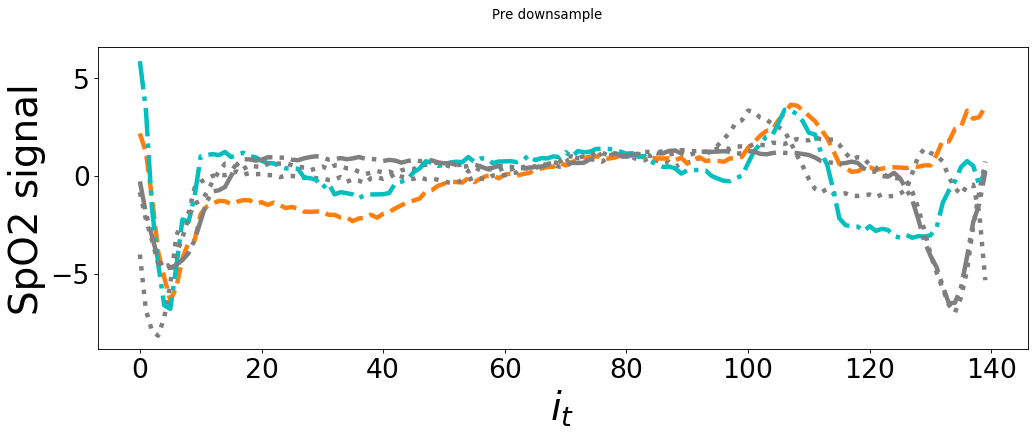

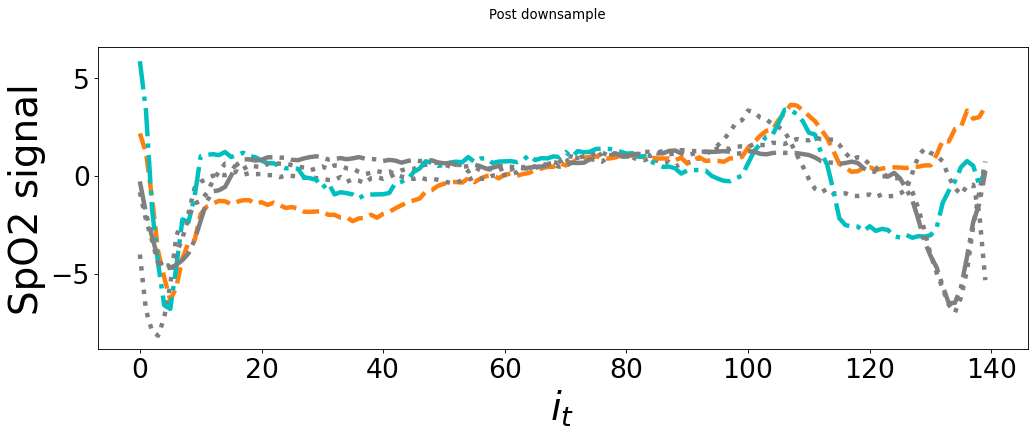

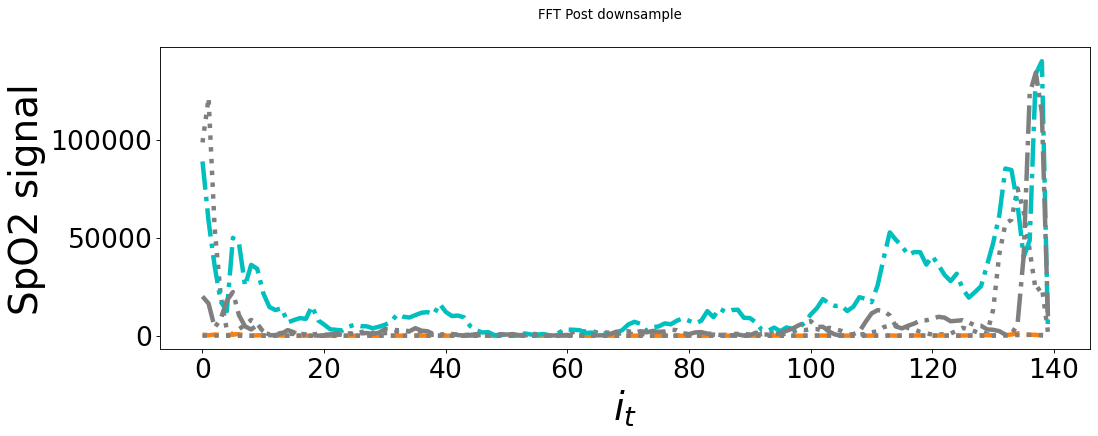

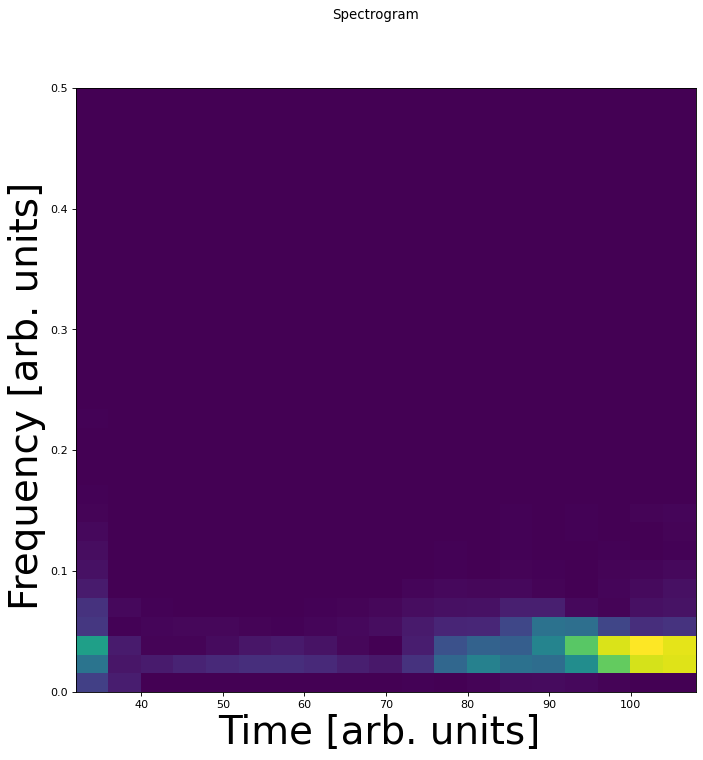

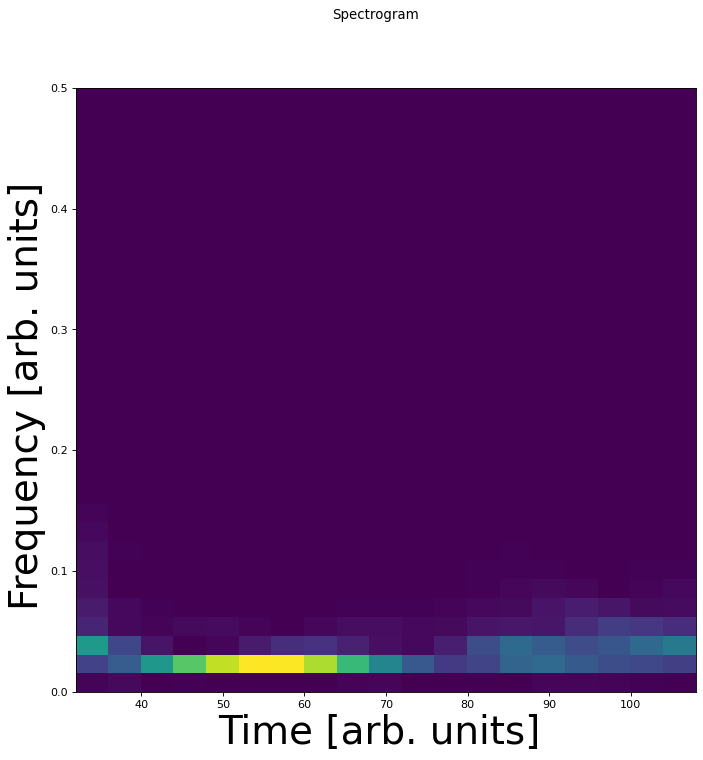

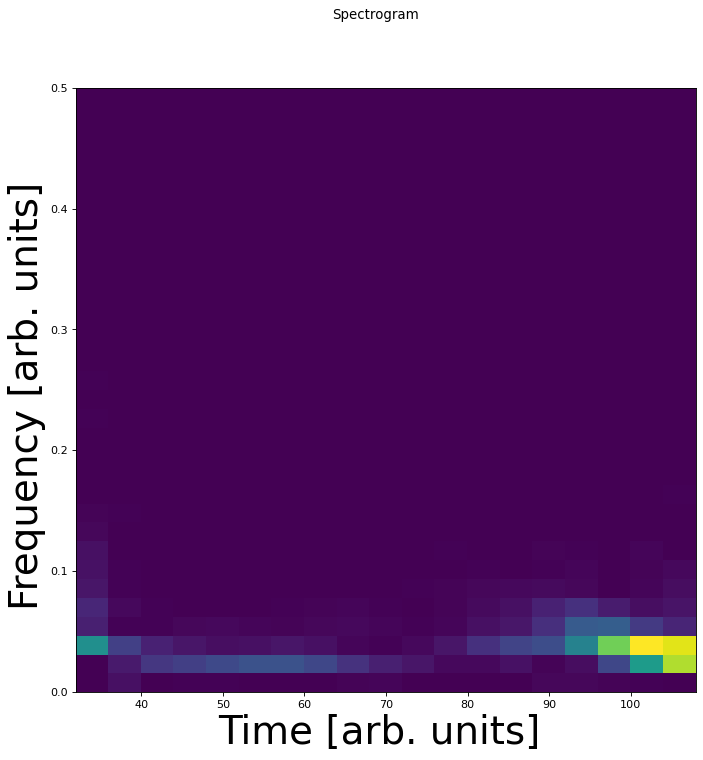

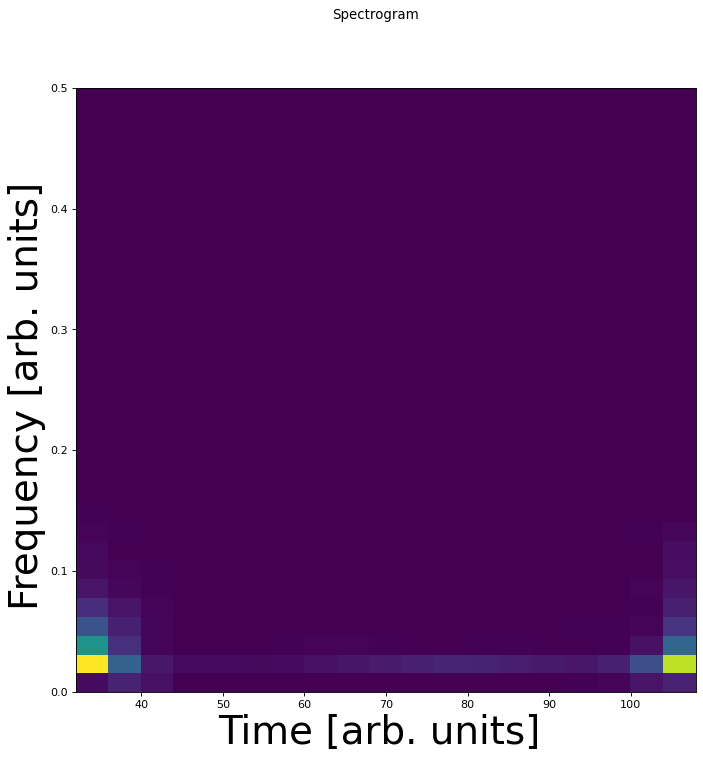

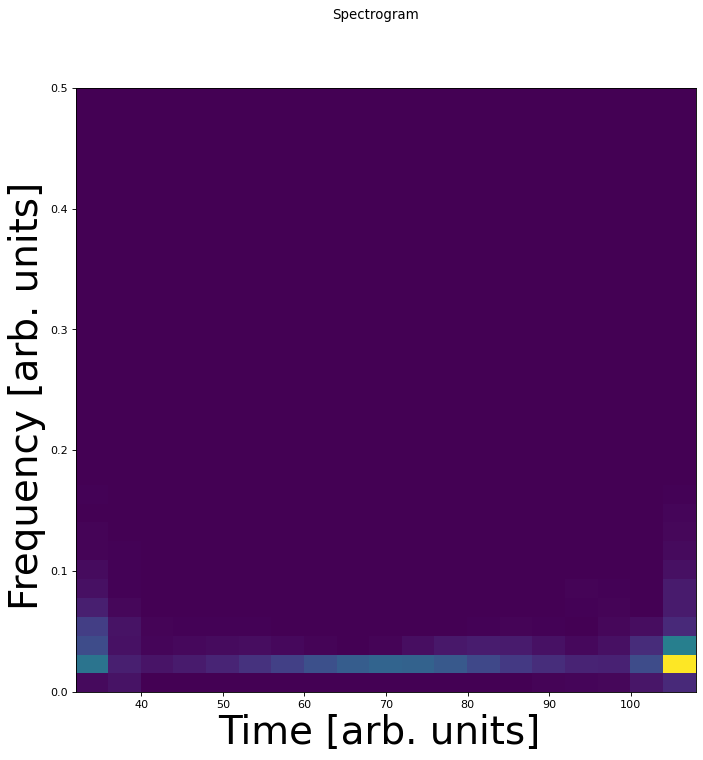

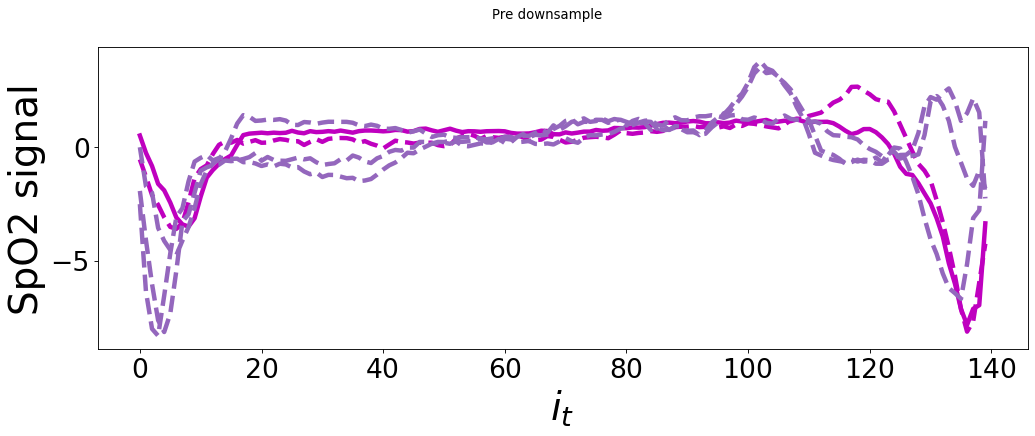

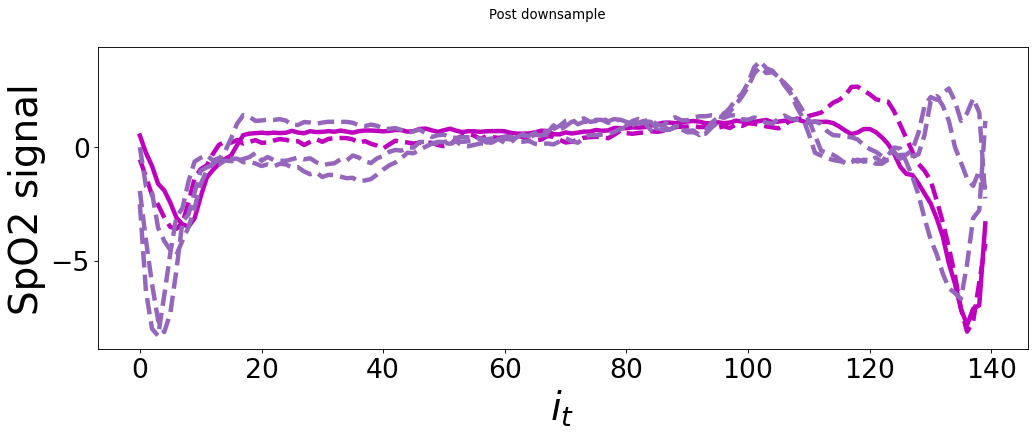

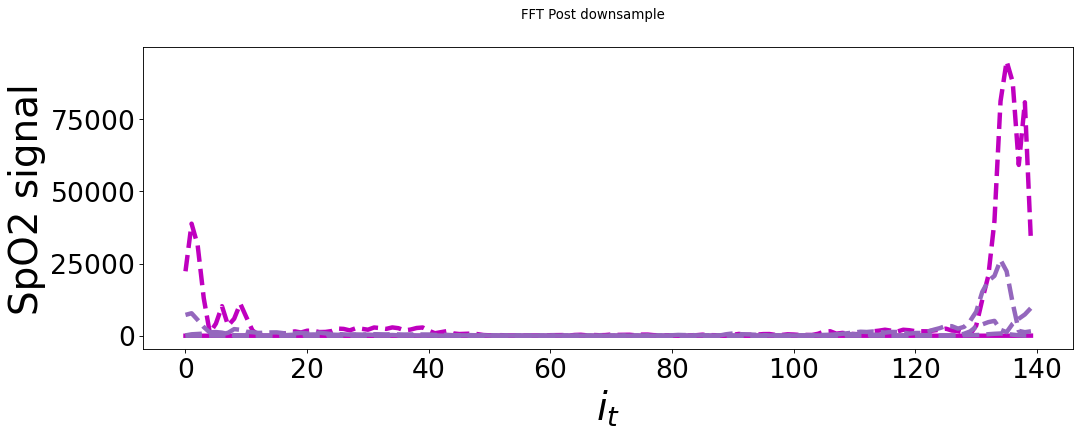

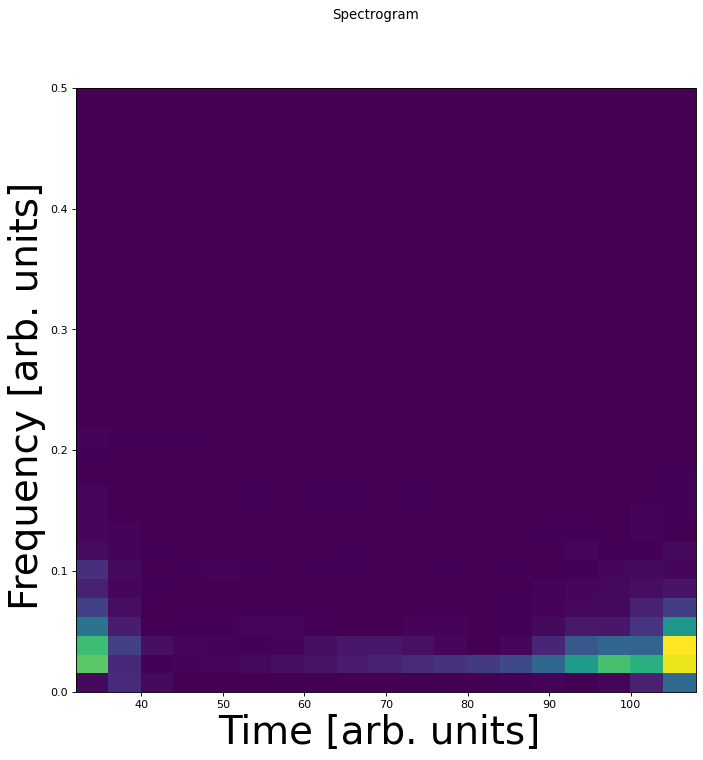

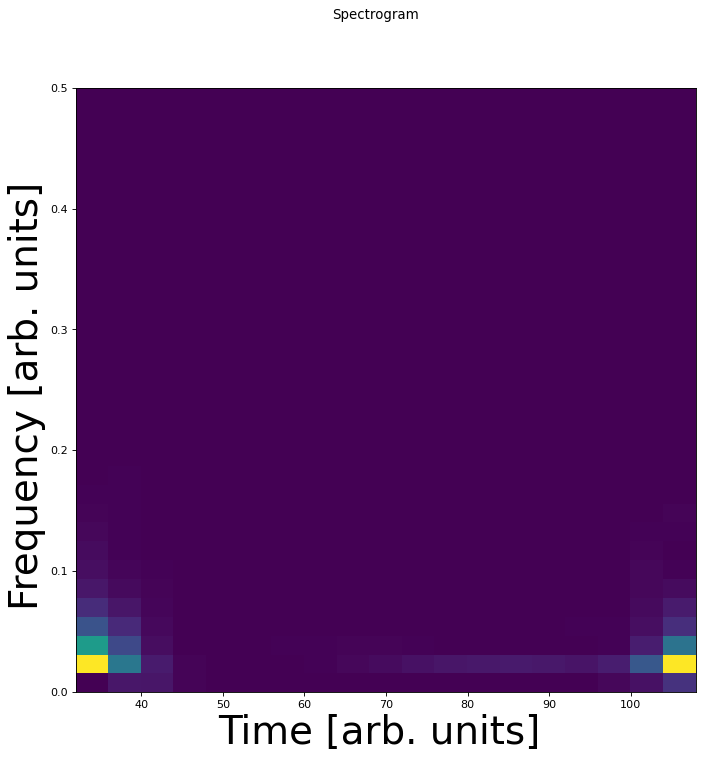

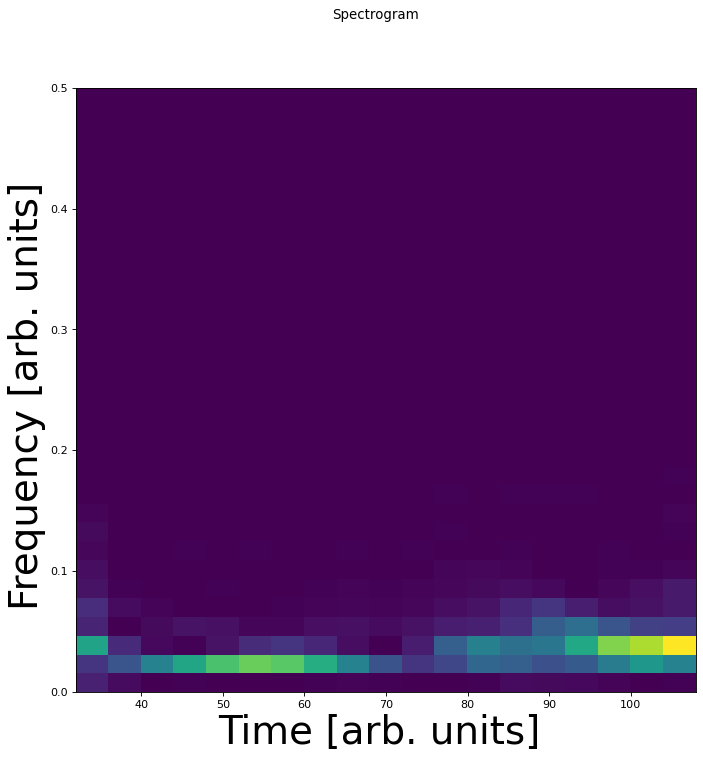

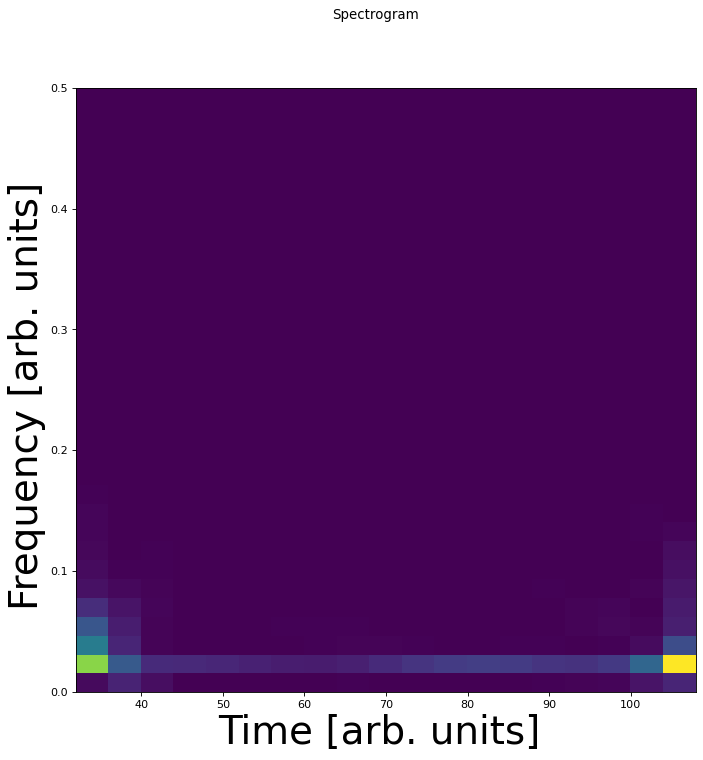

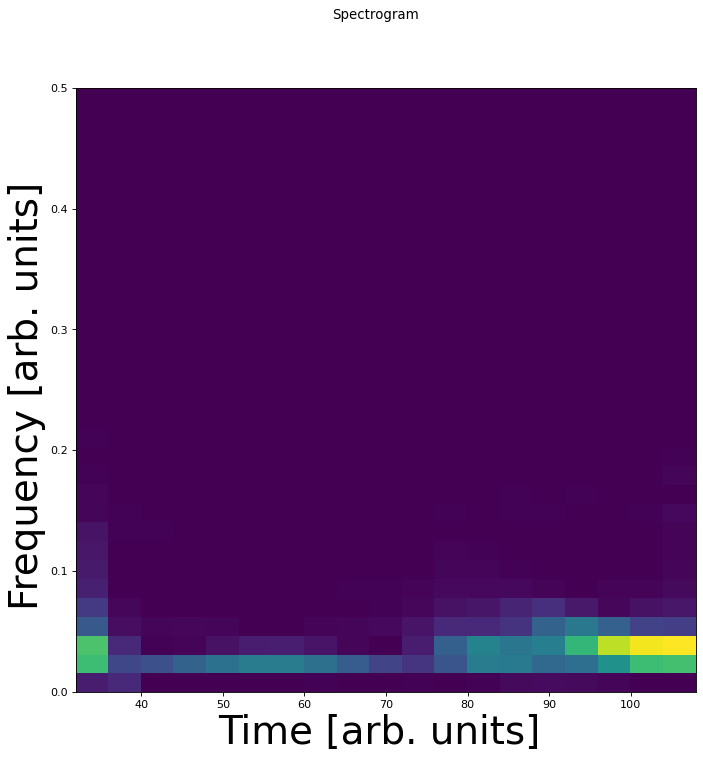

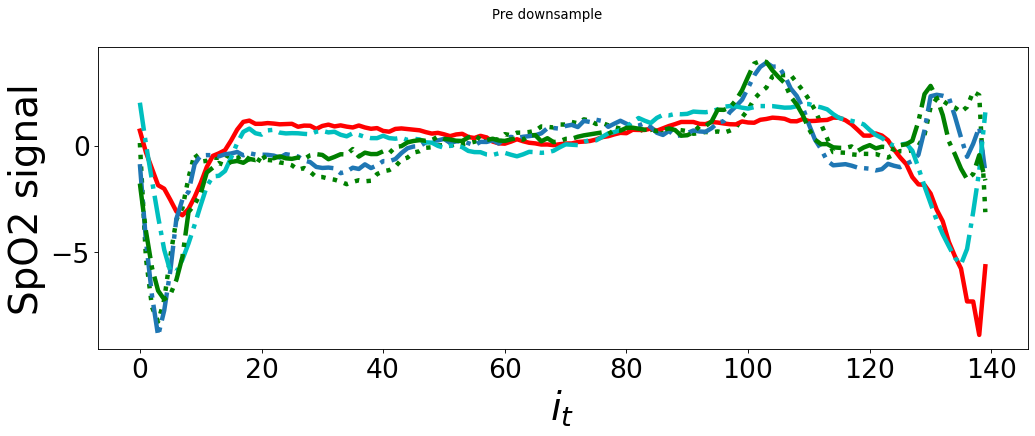

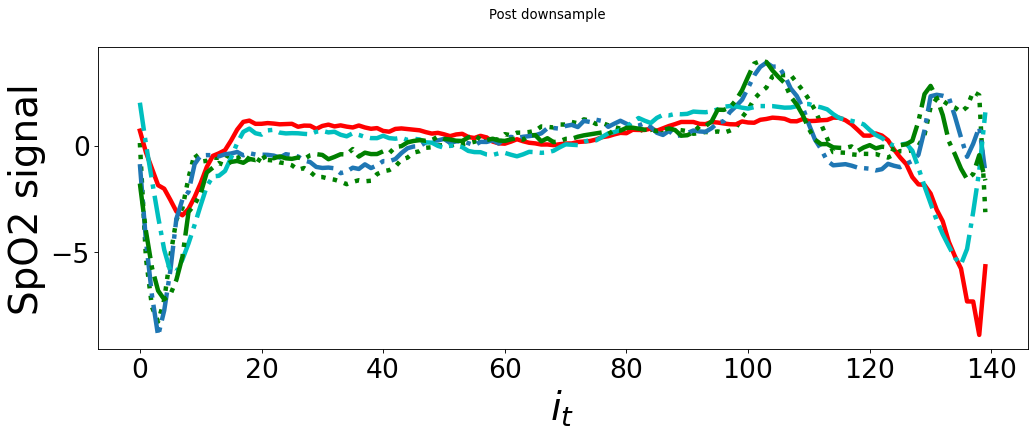

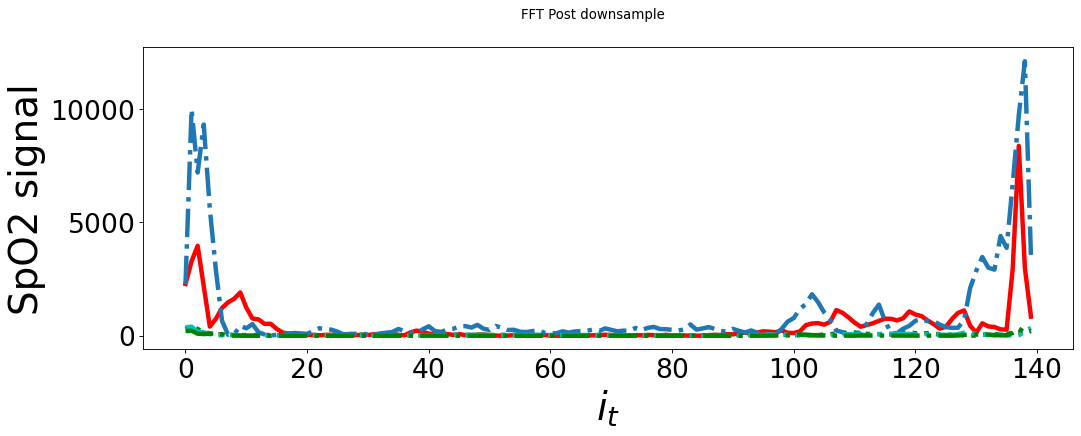

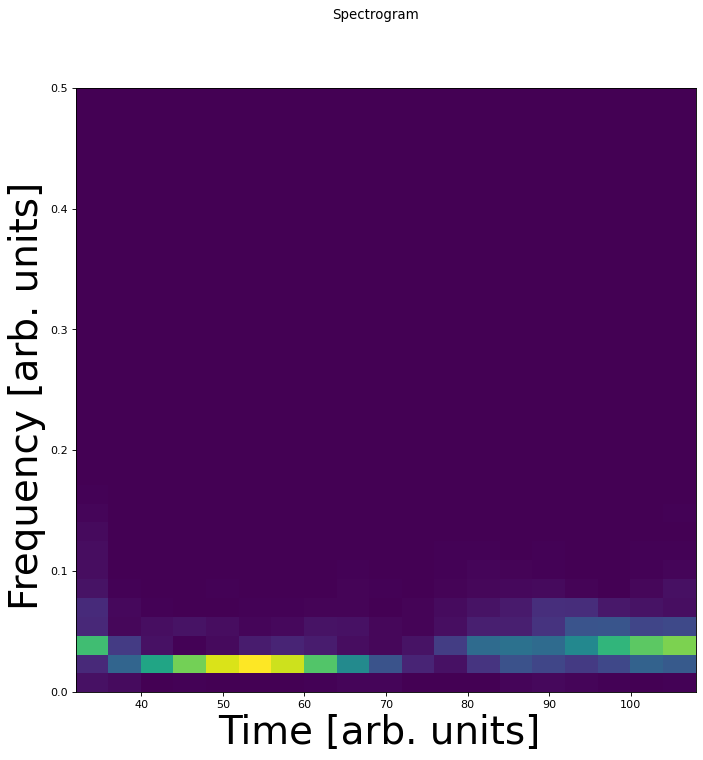

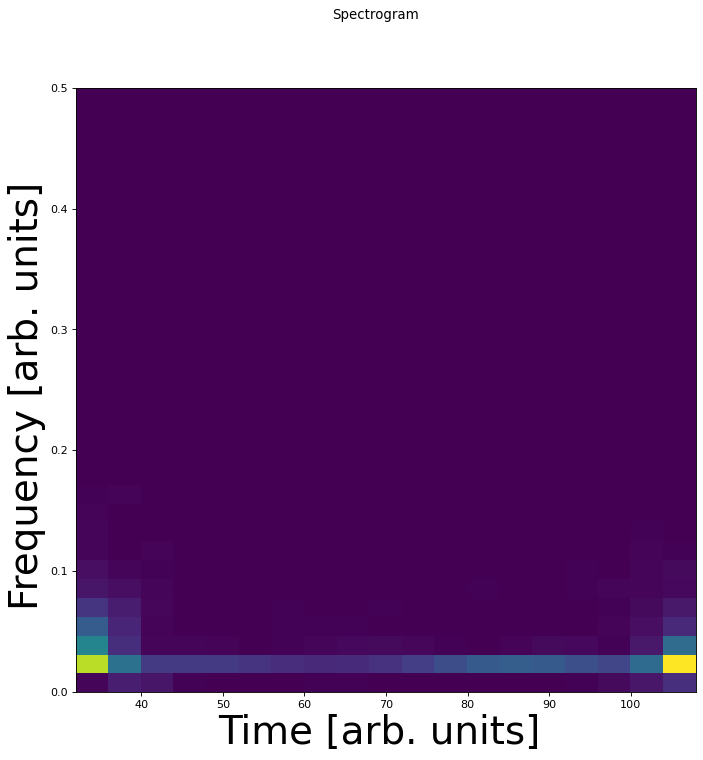

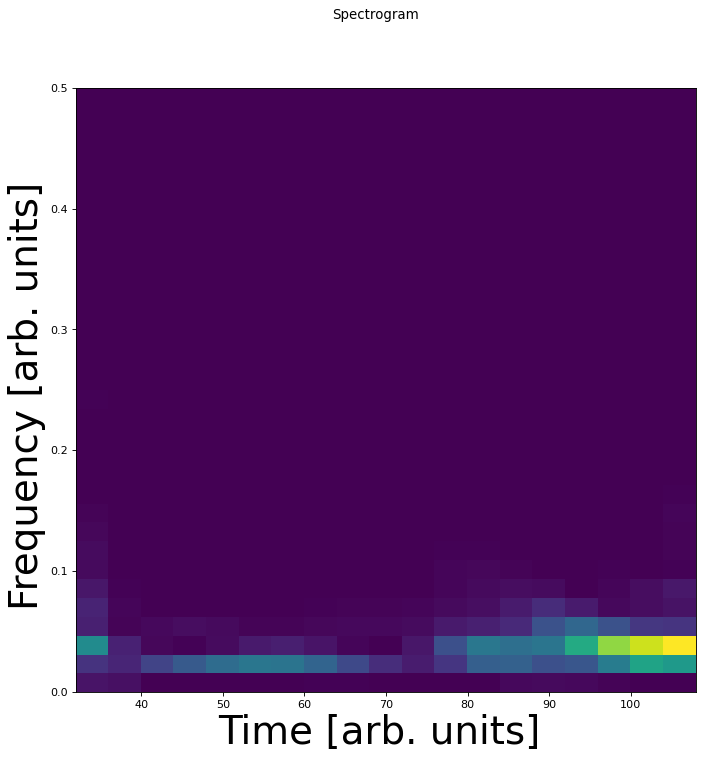

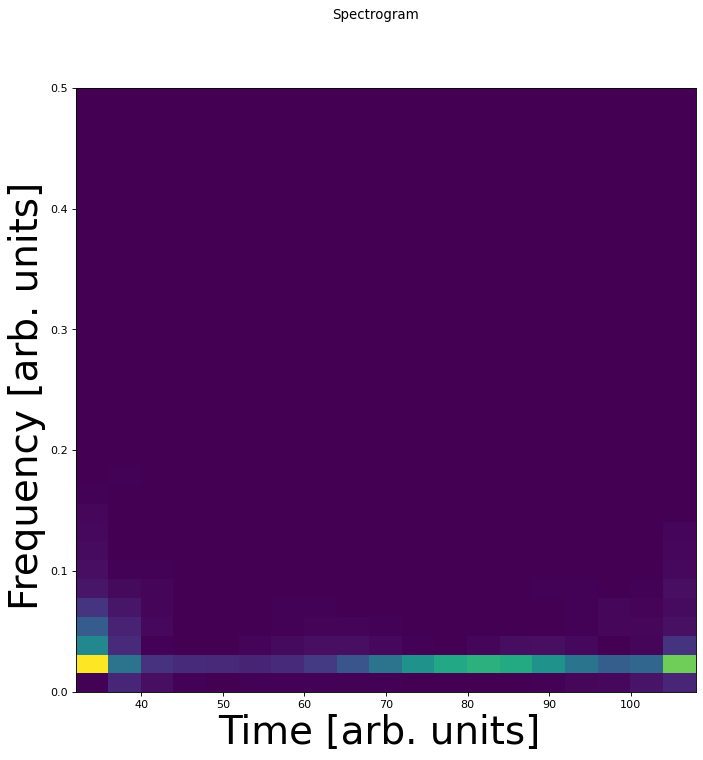

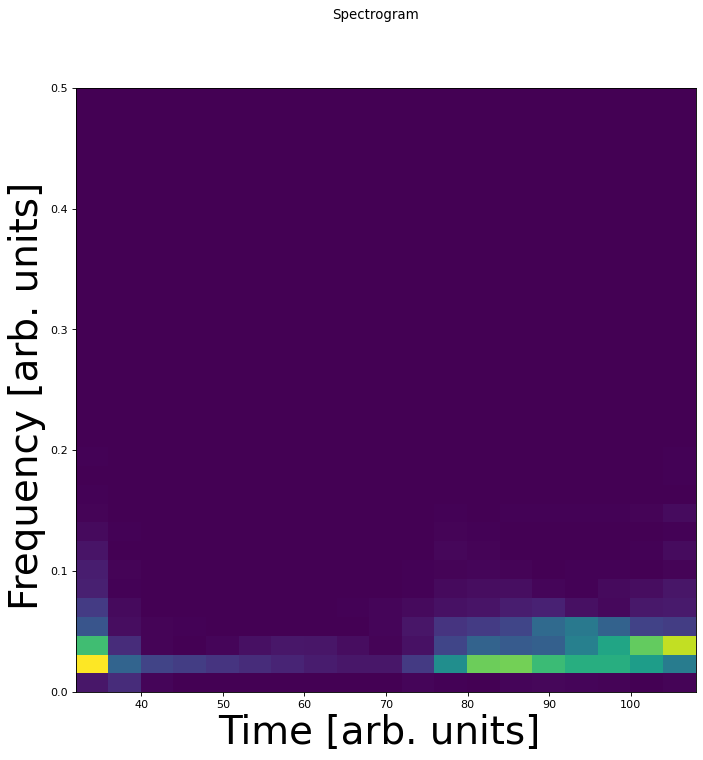

In [5]:
#trainDF=featured_tseries_df("train_SpO2seg.csv",downsample=4)
#valDF=featured_tseries_df("val_SpO2seg.csv",downsample=4)
#testDF=featured_tseries_df("test_SpO2seg.csv",downsample=4)
 

TSdsp1=TimeSeriesBundle("TSdsp1","../DatosOriginales/train_ecg.csv",\
                        "../DatosOriginales/val_ecg.csv",\
                        "../DatosOriginales/test_ecg.csv",\
            downsample=1,augment=1,diff=0)
#TSdsp2=TimeSeriesBundle("TSdsp2","../DatosOriginales/train_SpO2seg.csv",\
#                        "../DatosOriginales/ecg.csv","../DatosOriginales/ecg.csv",\
#            downsample=2,augment=1,diff=0)
#TSdsp4=TimeSeriesBundle("TSdsp4","../DatosOriginales/train_SpO2seg.csv",\
#                        "../DatosOriginales/val_SpO2seg.csv","../DatosOriginales/test_SpO2seg.csv",\
#            downsample=4,augment=1,diff=0)
#TSdsp8=TimeSeriesBundle("TSdsp8","../DatosOriginales/train_SpO2seg.csv",\
#                        "../DatosOriginales/val_SpO2seg.csv","../DatosOriginales/test_SpO2seg.csv",\
#            downsample=8,augment=1,diff=0)
#TSdsp16=TimeSeriesBundle("TSdsp16","../DatosOriginales/train_SpO2seg.csv",\
#                         "../DatosOriginales/val_SpO2seg.csv","../DatosOriginales/test_SpO2seg.csv",\
#            downsample=16,augment=1,diff=0)




In [6]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D,Flatten,Dense, Dropout
from keras.layers import Conv2D, MaxPool2D
from keras.layers import BatchNormalization,LayerNormalization
from keras.layers import LeakyReLU, Activation, LSTM, AveragePooling1D
#from keras_visualizer import visualizer
import keras
from keras import Input

### PAra solucionar prob de compatibilidad con cuCNN
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve,\
 roc_auc_score, precision_score, recall_score, plot_confusion_matrix, confusion_matrix
from sklearn.metrics import PrecisionRecallDisplay


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

from keras import backend as K

import tensorflow as tf

class NewSequentialModelazos2D():
    def __init__(self,BundleObj,modelname,nfiltLs,nbinsLs,nstrideLs,npoolLs,batchsize=20,epochs=15,learningR=0.01):
    
        self.model = Sequential() ## inicializamos un objeto de la clase Sequential
        
        assert(isinstance(BundleObj,TimeSeriesBundle)) ### check de que se trate de un objeto de la clase Bundle.
        self.BundleObj=BundleObj
        self.nline,self.nf,self.nt,self.nchan=np.shape(BundleObj.Train.SpecGram)    
        self.ncols=np.shape(BundleObj.Train.labeltab)[1]
        print("Train labeltab spread:", np.sum(self.BundleObj.Train.labeltab,axis=0))
        self.modelname=modelname
        self.nfiltLs=nfiltLs
        self.nbinsLs=nbinsLs
        self.npoolLs=npoolLs
        self.nstrideLs=nstrideLs
        self.batchsize=batchsize
        self.epochs=epochs
        #self.
        self.opti=keras.optimizers.Adam(learning_rate=learningR)#keras.optimizers.Adam(lr=learningR)

    def model_review(self):
        self.model.summary()
        #visualizer(self.model,format="png",view=True)
        
        
    def setup_model00(self):
        #assert(isinstance(GalleryObj,Gallery))

        ## entrada
        self.model.add(Conv2D(self.nfiltLs[0], (self.nbinsLs[0],self.nbinsLs[0]),\
            strides=(self.nstrideLs[0],self.nstrideLs[0]),input_shape=(self.nf,self.nt,1) ))
        self.model.add(Activation('selu'))
        #self.model.add(LeakyReLU(alpha=0.5))
        #self.model.add(LSTM(128))
        self.model.add(Flatten())
        #self.model.add(Dense( self.nt ) )
        #self.model.add(Activation('relu'))
        #self.model.add(LeakyReLU(alpha=0.05))
        self.model.add(Dense(self.ncols))
        self.model.add(Activation('sigmoid'))
        self.model_review()
        self.model.compile(loss='binary_crossentropy',optimizer=self.opti,metrics=['accuracy'])
                #### categorical_crossentropy
    def setup_model01(self):
        #assert(isinstance(GalleryObj,Gallery))

        ## entrada
        self.model.add(Conv2D(self.nfiltLs[0], (self.nbinsLs[0],self.nbinsLs[0]),\
            strides=(self.nstrideLs[0],self.nstrideLs[0]),input_shape=(self.nf,self.nt,1) ))
        self.model.add(Activation('selu'))
        #self.model.add(LeakyReLU(alpha=0.05))
        #self.model.add(AveragePooling1D( pool_size=(self.npoolLs[0],self.npoolLs[0]) ) )
        
        ## intermedio
        for inb,nb in enumerate(self.nbinsLs[1:],1):
            self.model.add(Conv2D(self.nfiltLs[inb], (nb,nb), strides=(self.nstrideLs[inb],self.nstrideLs[inb])))
            self.model.add(Activation('selu'))
            self.model.add(Conv2D(self.nfiltLs[inb], (nb,nb) ))
            self.model.add(Activation('selu'))
            #self.model.add(AveragePooling2D( pool_size=(self.npoolLs[inb],self.npoolLs[inb]) ))
        self.model.add(Flatten())
        #self.model.add(Dense( 10*int(np.sqrt(self.nt)),activation='relu'))
        self.model.add(Dense( self.nt)) 
        self.model.add(Activation('selu'))
        #self.model.add(LeakyReLU(alpha=0.05))
        self.model.add(Dense(self.ncols )) #,activation='sigmoid'))
        self.model.add(Activation('sigmoid'))
        self.model.compile(loss='categorical_crossentropy',optimizer=self.opti,metrics=['accuracy'])
    
    def setup_model02(self):
        #assert(isinstance(GalleryObj,Gallery))

        ## entrada
        self.model.add(Conv2D(self.nfiltLs[0], (self.nbinsLs[0],self.nbinsLs[0]) ,\
            strides=self.nstrideLs[0],input_shape=(self.nf,self.nt,1) ))#,activation='relu'))
        self.model.add(Activation('selu'))
        self.model.add(LeakyReLU(alpha=0.05))
        #self.model.add(AveragePooling2D( pool_size=(self.npoolLs[0],self.npoolLs[0]) ) )

        ## intermedio
        for inb,nb in enumerate(self.nbinsLs[1:],1):
            self.model.add(Conv2D(self.nfiltLs[inb], (nb,nb), strides=(self.nstrideLs[inb],self.nstrideLs[inb]) )) # ,activation='relu'))
            self.model.add(Activation('selu'))
            #self.model.add(LeakyReLU(alpha=0.05))
            self.model.add(Conv2D(self.nfiltLs[inb], (nb) )) #, activation='relu'))
            self.model.add(Activation('selu'))
            #self.model.add(LeakyReLU(alpha=0.05))
            self.model.add(Conv2D(self.nfiltLs[inb], (nb) )) #, activation='relu'))
            self.model.add(Activation('selu'))
            #self.model.add(AveragePooling2D(pool_size=(self.npoolLs[inb],self.npoolLs[inb]) ))
        self.model.add(Flatten())
        self.model.add(Dense( self.nt)) 
        self.model.add(Activation('selu'))
        self.model.add(Dense(self.ncols )) #,activation='sigmoid'))
        self.model.add(Activation('sigmoid'))
        self.model_review()
        self.model.compile(loss='categorical_crossentropy',optimizer=self.opti,metrics=['accuracy'])
        
        
    def setup_model03(self):
        #assert(isinstance(GalleryObj,Gallery))

        ## entrada
        self.model.add(Conv2D(self.nfiltLs[0], (self.nbinsLs[0],self.nbinsLs[0]),\
            strides=(self.nstrideLs[0],self.nstrideLs[0]),input_shape=(self.nf,self.nt,1))) # ,activation='relu'))
        self.model.add(Activation('selu'))
        #self.model.add(LeakyReLU(alpha=0.05))
        #self.model.add(MaxPool2D( pool_size=(self.npoolLs[0],self.npoolLs[0]) ) )
        ## intermedio
        for inb,nb in enumerate(self.nbinsLs[1:],1):
                       
            self.model.add(Conv2D(self.nfiltLs[inb], (nb,nb), strides=(self.nstrideLs[inb],self.nstrideLs[inb]) )) #,activation='relu'))
            self.model.add(Activation('selu'))
            #self.model.add(LeakyReLU(alpha=0.05))
            self.model.add(Conv2D(self.nfiltLs[inb], (nb,nb) ))#, activation='relu'))
            self.model.add(Activation('selu'))
            #self.model.add(LeakyReLU(alpha=0.1))
            self.model.add(Dropout(0.10))
            self.model.add(Conv2D(self.nfiltLs[inb], (nb,nb) )) #, activation='relu'))
            #self.model.add(MaxPool2D(pool_size=(self.npoolLs[inb],self.npoolLs[inb]) ))
        self.model.add(Flatten())
        #self.model.add(Dense(10* int(np.sqrt(self.nt)),activation='relu'))
        self.model.add(Dense(self.ncols )) #,activation='sigmoid'))  ### "softmax","sigmoid"
        self.model.add(Activation('sigmoid'))
        self.model_review()
        
        self.model.compile(loss='categorical_crossentropy',optimizer=self.opti,metrics=['accuracy'])
 

        
    def run_model(self):
        print("Val labeltab spread:", np.sum(self.BundleObj.Val.labeltab,axis=0))
        self.history=self.model.fit(self.BundleObj.Train.SpecGram, self.BundleObj.Train.labeltab,
              batch_size=self.batchsize,
              epochs=self.epochs,
              validation_data=(self.BundleObj.Val.SpecGram, self.BundleObj.Val.labeltab))

        #model0.summary()
        #print(self.history.history.keys())
        #return model0,history0
        
    def plot_history(self):
        histDF=pd.DataFrame(self.history.history)
        histDF["epoch"]=self.history.epoch

        fig = plt.figure(figsize=(15.0, 5.0), dpi=80)
        fig.set_frameon(False)

        fig.suptitle("Training and Validation Loss")
        ax1 = fig.add_subplot(111)
        ax4=fig.add_subplot(111) 
        #ax1.set_ylim(yscale[0],yscale[1])
        #ax1.set_ylim(yscale[0],yscale[1])

        ax1.set_xlabel('Epoch ', fontsize = 35)
        ax1.set_ylabel('Loss function', fontsize = 35)
        ax4.set_xlabel('Epoch ', fontsize = 35)
        ax4.set_ylabel('Loss function', fontsize = 35)  
        #plt.figure()
        #plt.xlabel("Epoch")
        #plt.ylabel("Loss function" )
        ax1.plot(histDF["epoch"],histDF["loss"],"r--",label="Training Loss")
        ax1.plot(histDF["epoch"],histDF["val_loss"],"b-.",label="Validation Loss")

        #plt.ylim([0,0.5])
        ax1.legend()
        plt.show()
        plt.savefig("Ej2_Loss_"+self.modelname+"_"+ \
                    self.BundleObj.name+"_"+".png", bbox_inches='tight', dpi=100)
        #################################################################
        fig = plt.figure(figsize=(15.0, 5.0), dpi=80)
        fig.set_frameon(False)

        fig.suptitle("Training and Validation Accuracy")
        ax1 = fig.add_subplot(111)
        ax4=fig.add_subplot(111) 
        #ax1.set_ylim(yscale[0],yscale[1])
        #ax1.set_ylim(yscale[0],yscale[1])

        ax1.set_xlabel('Epoch ', fontsize = 35)
        ax1.set_ylabel('Accuracy', fontsize = 35)
        ax4.set_xlabel('Epoch ', fontsize = 35)
        ax4.set_ylabel('Accuracy', fontsize = 35)  
        ax1.plot(histDF["epoch"],histDF["accuracy"],"r--",label="Training Acc.")
        ax1.plot(histDF["epoch"],histDF["val_accuracy"],"b-.",label="Validation Acc.")
        ax1.legend()
        #plt.ylim([0,0.5])
        
        plt.show()
        plt.savefig("Ej2_Acc_"+self.modelname+"_"+ \
                    self.BundleObj.name+"_"+".png", bbox_inches='tight', dpi=100)
        
    def predict(self):
         self.pred= np.argmax(self.model.predict(self.BundleObj.Test.SpecGram),axis=-1)

    def make_confusion_mat(self,TestTrue):
        pass
        self.results={}
        
        self.confmat=pd.crosstab(TestTrue,self.pred  )
        self.confmatNP=self.confmat.to_numpy()
        truetrue=np.sum(np.diagonal(self.confmatNP ))
        accu=truetrue/np.sum(self.confmatNP )
        print("Test Accuracy :", accu)
        print(self.confmat)
        self.TestTrue=TestTrue
        #recall=
        self.results["accu"]=accu
        self.results["recall"]=self.confmatNP[1,1] /np.sum(self.confmatNP[1,:])
        self.results["specif"]=self.confmatNP[0,0] /np.sum(self.confmatNP[0,:]) 
        self.results["ppv"]=self.confmatNP[1,1] /np.sum(self.confmatNP[:,1])
        self.results["npv"]=self.confmatNP[0,0] /np.sum(self.confmatNP[:,0]) 
        
        
        
        
        fig = plt.figure(figsize=(5.0, 5.0), dpi=80)
        plt.clf()
        ax = fig.add_subplot(111)
        ax.set_aspect(1)
        #self.confmat.pivot("True label", "Predicted label", "N")
        res = sn.heatmap(self.confmat, annot=True, fmt='.2f', cmap="YlGnBu", cbar=False)
        res.set_xlabel("Predicted label")
        res.set_ylabel("True label")
        plt.savefig("confmat_"+self.modelname+"_"+self.BundleObj.name+"_"+".png",\
                    bbox_inches='tight', dpi=100)
        plt.show()
           
    
    

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7716866502346999002
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13203384997703993771
physical_device_desc: "device: XLA_CPU device"
]
Train labeltab spread: [2914. 4086.]
RUNNING BUNDLE  TSdsp1  with model  model00
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 18, 15)        150       
_________________________________________________________________
activation (Activation)      (None, 31, 18, 15)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8370)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16742     
____________________

28/28 [==============================] - 0s 7ms/step - loss: 0.5623 - accuracy: 0.7551 - val_loss: 0.5776 - val_accuracy: 0.7417
Epoch 50/50
28/28 [==============================] - 0s 8ms/step - loss: 0.5622 - accuracy: 0.7570 - val_loss: 0.5775 - val_accuracy: 0.7417


<ipython-input-6-cab6e0f8e18f>:177: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


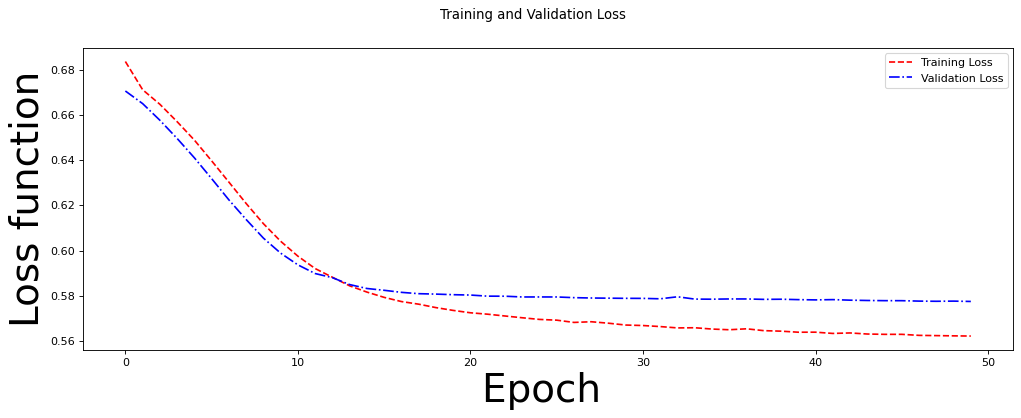

<ipython-input-6-cab6e0f8e18f>:202: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

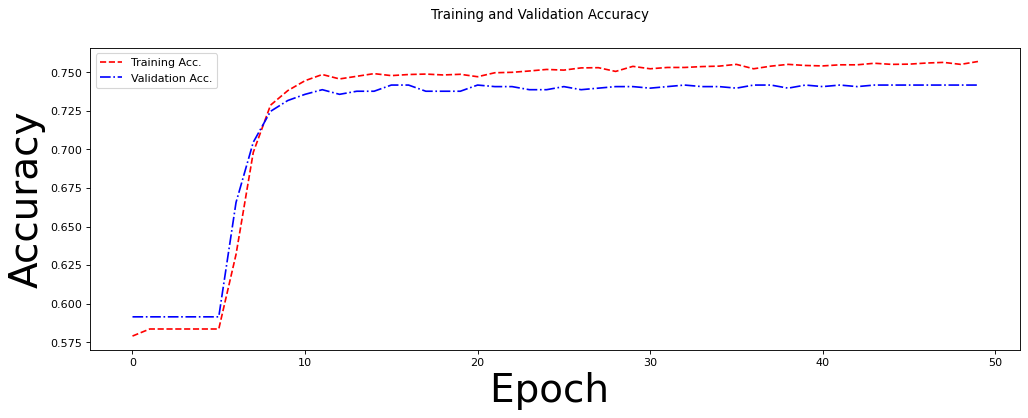

Test Accuracy : 0.7294589178356713
col_0    0    1
row_0          
0      292  136
1      134  436


<Figure size 432x288 with 0 Axes>

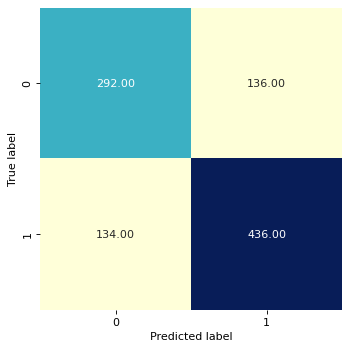

Train labeltab spread: [2914. 4086.]
RUNNING BUNDLE  TSdsp1  with model  model01
Val labeltab spread: [ 816. 1182.]
Epoch 1/50
28/28 [==============================] - 0s 11ms/step - loss: 0.6720 - accuracy: 0.5814 - val_loss: 0.6521 - val_accuracy: 0.5916
Epoch 2/50
28/28 [==============================] - 0s 8ms/step - loss: 0.6415 - accuracy: 0.5909 - val_loss: 0.6173 - val_accuracy: 0.6517
Epoch 3/50
28/28 [==============================] - 0s 8ms/step - loss: 0.6033 - accuracy: 0.7307 - val_loss: 0.5869 - val_accuracy: 0.7387
Epoch 4/50
28/28 [==============================] - 0s 8ms/step - loss: 0.5801 - accuracy: 0.7477 - val_loss: 0.5794 - val_accuracy: 0.7417
Epoch 5/50
28/28 [==============================] - 0s 8ms/step - loss: 0.5716 - accuracy: 0.7467 - val_loss: 0.5789 - val_accuracy: 0.7357
Epoch 6/50
28/28 [==============================] - 0s 8ms/step - loss: 0.5676 - accuracy: 0.7483 - val_loss: 0.5762 - val_accuracy: 0.7417
Epoch 7/50
28/28 [=========================

<ipython-input-6-cab6e0f8e18f>:177: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


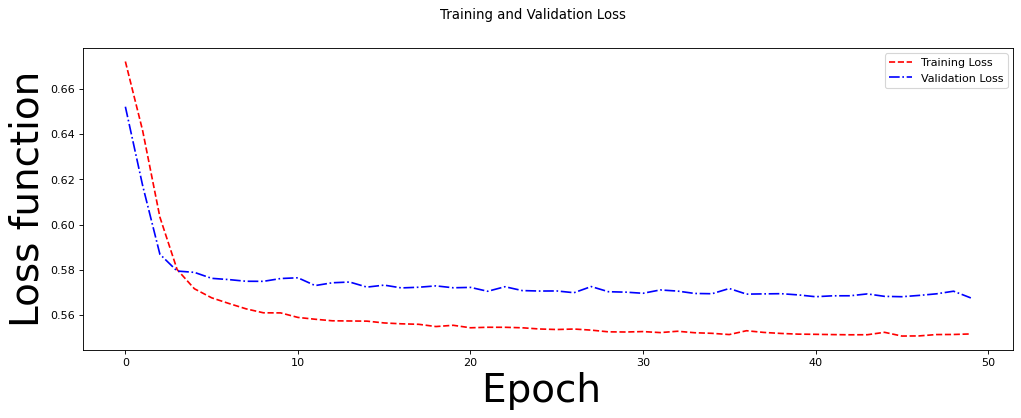

<ipython-input-6-cab6e0f8e18f>:202: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

Test Accuracy : 0.7274549098196392
col_0    0    1
row_0          
0      287  141
1      131  439


<Figure size 432x288 with 0 Axes>

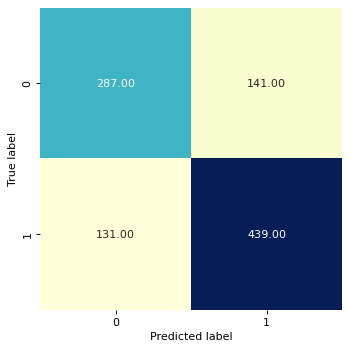

Train labeltab spread: [2914. 4086.]
RUNNING BUNDLE  TSdsp1  with model  model02
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 31, 18, 15)        150       
_________________________________________________________________
activation_5 (Activation)    (None, 31, 18, 15)        0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 31, 18, 15)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8370)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                167420    
_________________________________________________________________
activation_6 (Activation)    (None, 20)                0         
_______________________________________

28/28 [==============================] - 0s 10ms/step - loss: 0.5527 - accuracy: 0.7566 - val_loss: 0.5712 - val_accuracy: 0.7407
Epoch 49/50
28/28 [==============================] - 0s 9ms/step - loss: 0.5527 - accuracy: 0.7571 - val_loss: 0.5724 - val_accuracy: 0.7427
Epoch 50/50
28/28 [==============================] - 0s 9ms/step - loss: 0.5528 - accuracy: 0.7569 - val_loss: 0.5724 - val_accuracy: 0.7427


<ipython-input-6-cab6e0f8e18f>:177: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


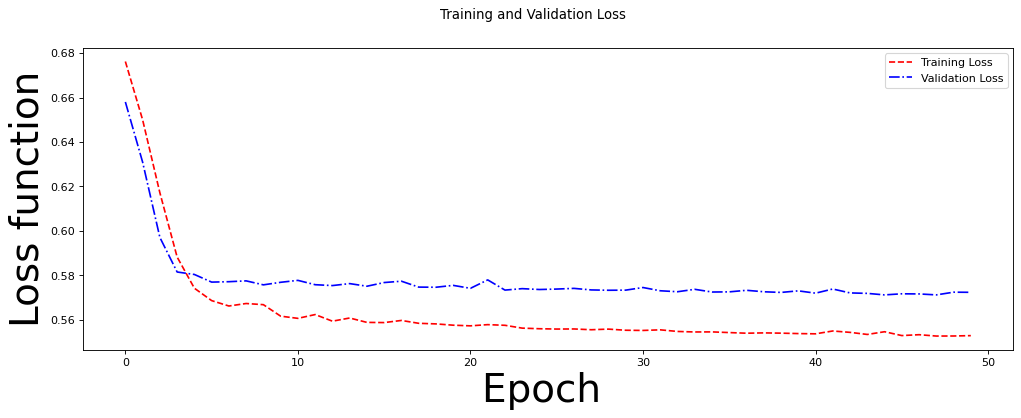

<ipython-input-6-cab6e0f8e18f>:202: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

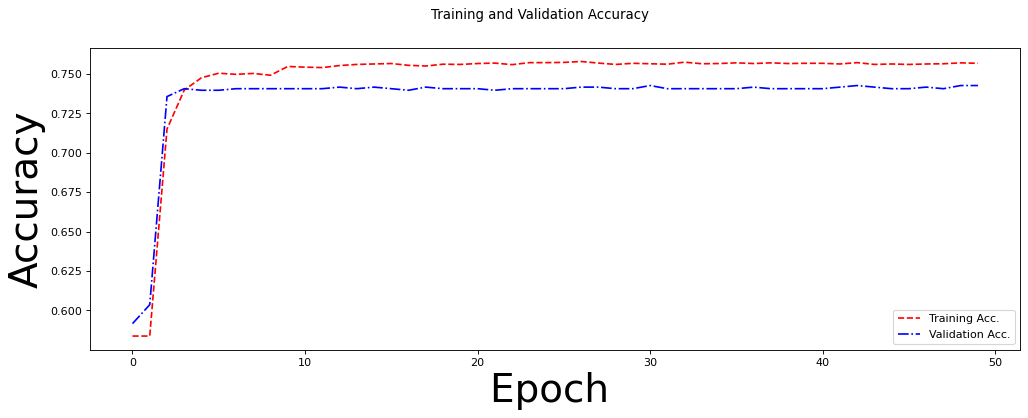

Test Accuracy : 0.7294589178356713
col_0    0    1
row_0          
0      288  140
1      130  440


<Figure size 432x288 with 0 Axes>

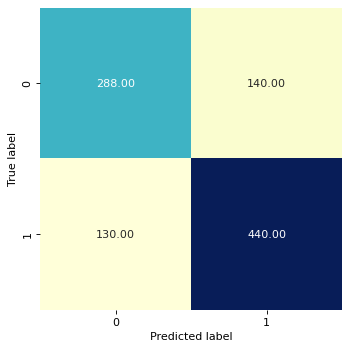

Train labeltab spread: [2914. 4086.]
RUNNING BUNDLE  TSdsp1  with model  model03
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 31, 18, 15)        150       
_________________________________________________________________
activation_8 (Activation)    (None, 31, 18, 15)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8370)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 16742     
_________________________________________________________________
activation_9 (Activation)    (None, 2)                 0         
Total params: 16,892
Trainable params: 16,892
Non-trainable params: 0
_________________________________________________________________
Val labeltab spread: [ 816. 1182.]


<ipython-input-6-cab6e0f8e18f>:177: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


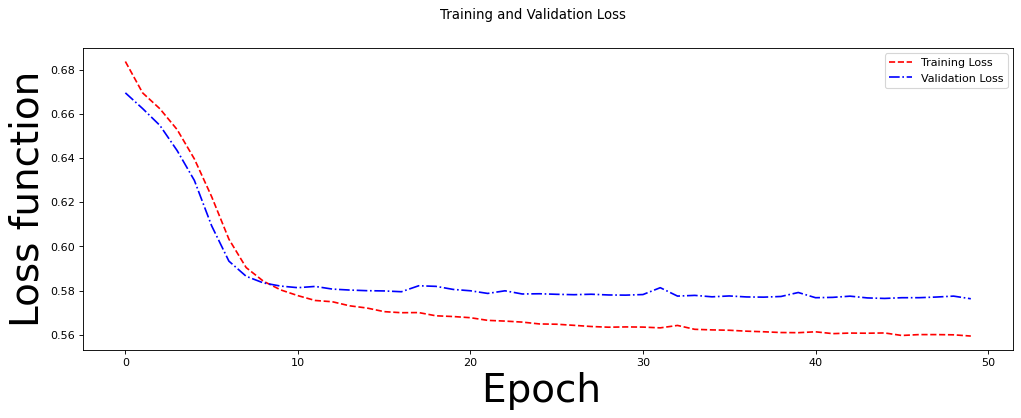

<ipython-input-6-cab6e0f8e18f>:202: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

Test Accuracy : 0.7294589178356713
col_0    0    1
row_0          
0      289  139
1      131  439


<Figure size 432x288 with 0 Axes>

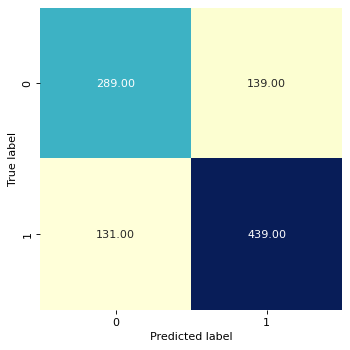

In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.Session(config=config)

ModelNamesLs2=["model00","model01","model02","model03"]

ModelsLs2=[]  #BundleLs
BundleLs2=[TSdsp1]
BigResuDF={"model":[],"bundle":[],"accu":[],"recall":[],"specif":[],"ppv":[],"npv":[]}
ResuLsAtt=["accu","recall","specif","ppv","npv"]
for iBund, Bund in enumerate(BundleLs2):
    
    for Mo in ModelNamesLs2:
    #    NewSequentialModelazos2D(self;; BundleObj,modelname,nfiltLs,\
    #nbinsLs,nstrideLs,npoolLs,batchsize=20,epochs=15,learningR=0.01):
    
        ModObj=NewSequentialModelazos2D(Bund,Mo,[15],[3],[1],[2],batchsize=256,\
                                    epochs=50,learningR=0.0002)
        print("RUNNING BUNDLE ", Bund.name," with model ", ModObj.modelname)
        
        func="setup_"+Mo
        #model0,history0=make_and_run_model0(Gal,[16,12],[5,3],[2,2],batchsize=20)
        ModelsLs2.append(ModObj)
        getattr(ModObj,func)()
        ModObj.run_model()
        ModObj.plot_history()
        ModObj.predict()
        ModObj.make_confusion_mat(np.argmax(Bund.Test.labeltab,axis=-1))
        
        
        BigResuDF["model"].append(ModObj.modelname)
        BigResuDF["bundle"].append(Bund.name)
        for key in ResuLsAtt:
            BigResuDF[key].append(ModObj.results[key] )
        #BigResuDF["accu"].append(ModObj.results["accu"])

Train labeltab spread: [2914. 4086.]
RUNNING BUNDLE  TSdsp1  with model  model00
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 31, 18, 128)       1280      
_________________________________________________________________
activation_10 (Activation)   (None, 31, 18, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 71424)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 142850    
_________________________________________________________________
activation_11 (Activation)   (None, 2)                 0         
Total params: 144,130
Trainable params: 144,130
Non-trainable params: 0
_________________________________________________________________
Val labeltab spread: [ 816. 1182.

<ipython-input-6-cab6e0f8e18f>:177: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


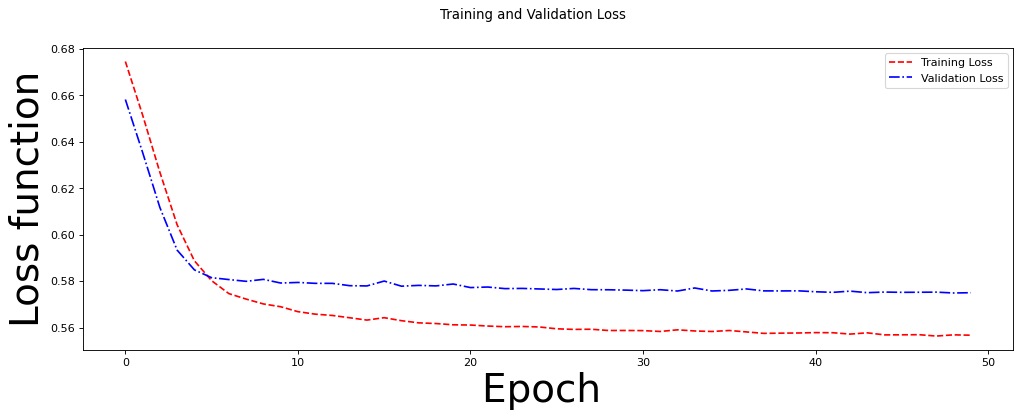

<ipython-input-6-cab6e0f8e18f>:202: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

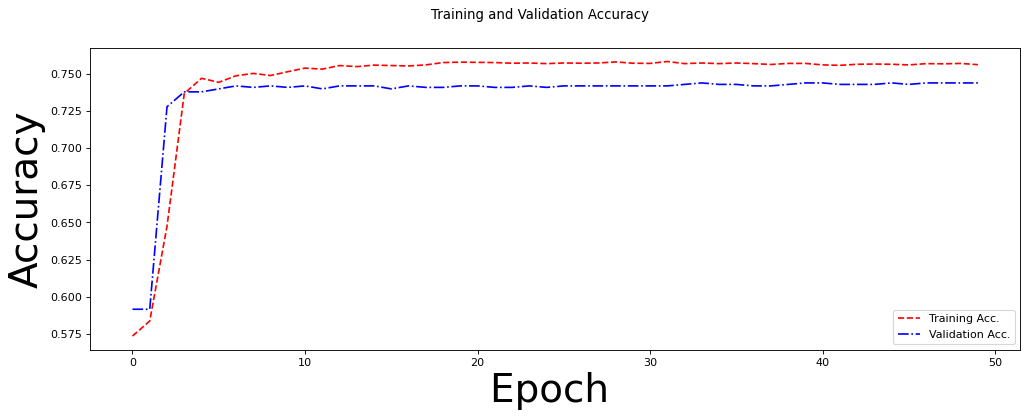

Test Accuracy : 0.7294589178356713
col_0    0    1
row_0          
0      289  139
1      131  439


<Figure size 432x288 with 0 Axes>

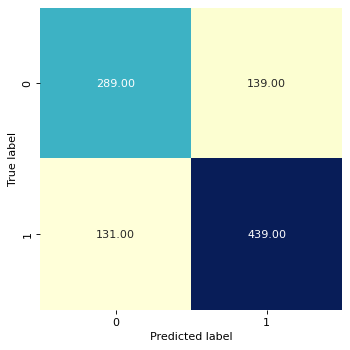

Train labeltab spread: [2914. 4086.]
RUNNING BUNDLE  TSdsp1  with model  model01
Val labeltab spread: [ 816. 1182.]
Epoch 1/50
28/28 [==============================] - 2s 87ms/step - loss: 0.6347 - accuracy: 0.6461 - val_loss: 0.5842 - val_accuracy: 0.7387
Epoch 2/50
28/28 [==============================] - 2s 85ms/step - loss: 0.5723 - accuracy: 0.7496 - val_loss: 0.5776 - val_accuracy: 0.7407
Epoch 3/50
28/28 [==============================] - 2s 86ms/step - loss: 0.5631 - accuracy: 0.7540 - val_loss: 0.5761 - val_accuracy: 0.7417
Epoch 4/50
28/28 [==============================] - 3s 91ms/step - loss: 0.5595 - accuracy: 0.7560 - val_loss: 0.5744 - val_accuracy: 0.7417
Epoch 5/50
28/28 [==============================] - 2s 87ms/step - loss: 0.5581 - accuracy: 0.7561 - val_loss: 0.5743 - val_accuracy: 0.7407
Epoch 6/50
28/28 [==============================] - 2s 85ms/step - loss: 0.5568 - accuracy: 0.7574 - val_loss: 0.5732 - val_accuracy: 0.7417
Epoch 7/50
28/28 [====================

<ipython-input-6-cab6e0f8e18f>:177: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


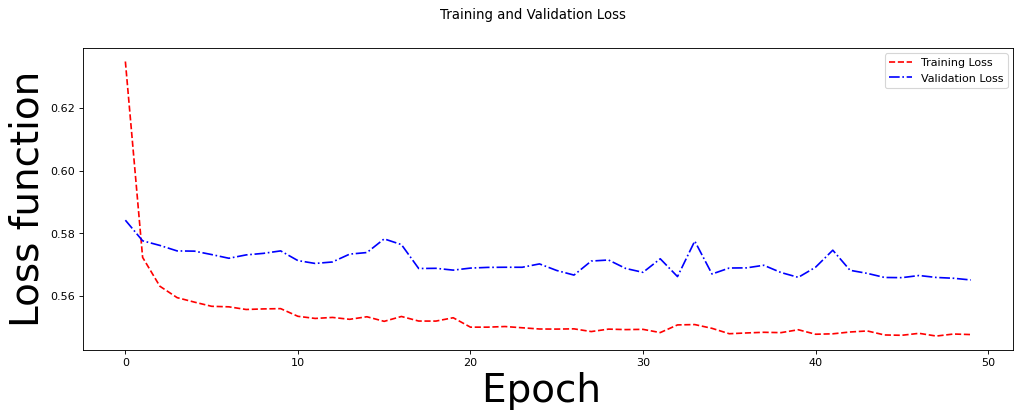

<ipython-input-6-cab6e0f8e18f>:202: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

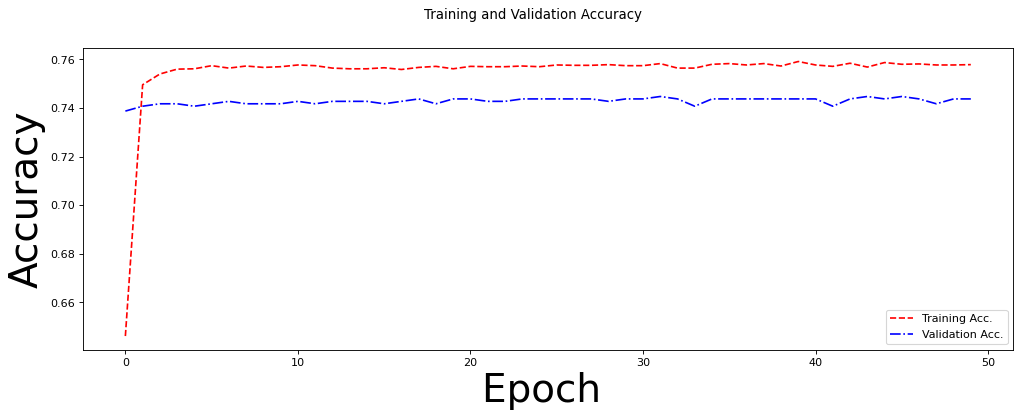

Test Accuracy : 0.7294589178356713
col_0    0    1
row_0          
0      291  137
1      133  437


<Figure size 432x288 with 0 Axes>

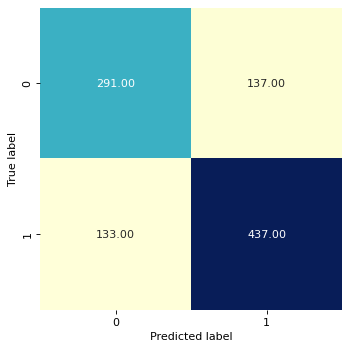

Train labeltab spread: [2914. 4086.]
RUNNING BUNDLE  TSdsp1  with model  model02
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 18, 128)       1280      
_________________________________________________________________
activation_15 (Activation)   (None, 31, 18, 128)       0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 31, 18, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 71424)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 20)                1428500   
_________________________________________________________________
activation_16 (Activation)   (None, 20)                0         
_______________________________________

28/28 [==============================] - 3s 107ms/step - loss: 0.5484 - accuracy: 0.7586 - val_loss: 0.5680 - val_accuracy: 0.7447
Epoch 48/50
28/28 [==============================] - 3s 108ms/step - loss: 0.5487 - accuracy: 0.7581 - val_loss: 0.5673 - val_accuracy: 0.7437
Epoch 49/50
28/28 [==============================] - 3s 109ms/step - loss: 0.5480 - accuracy: 0.7581 - val_loss: 0.5660 - val_accuracy: 0.7437
Epoch 50/50
28/28 [==============================] - 3s 108ms/step - loss: 0.5483 - accuracy: 0.7590 - val_loss: 0.5690 - val_accuracy: 0.7427


<ipython-input-6-cab6e0f8e18f>:177: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


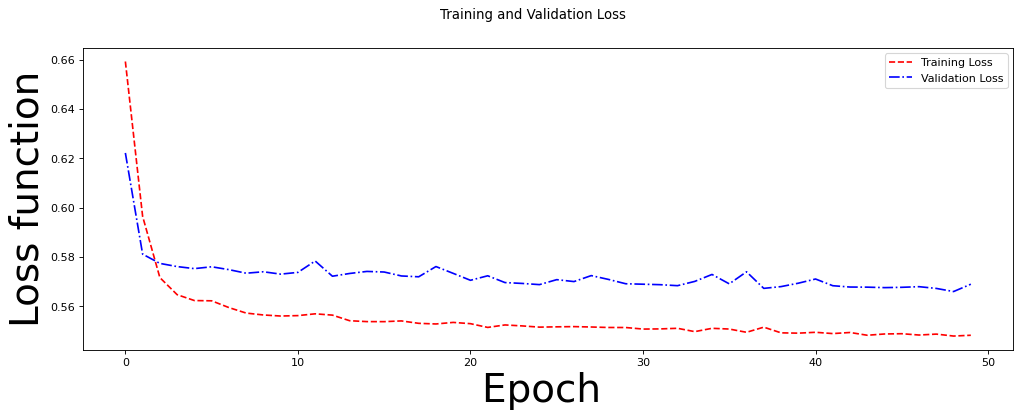

<ipython-input-6-cab6e0f8e18f>:202: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

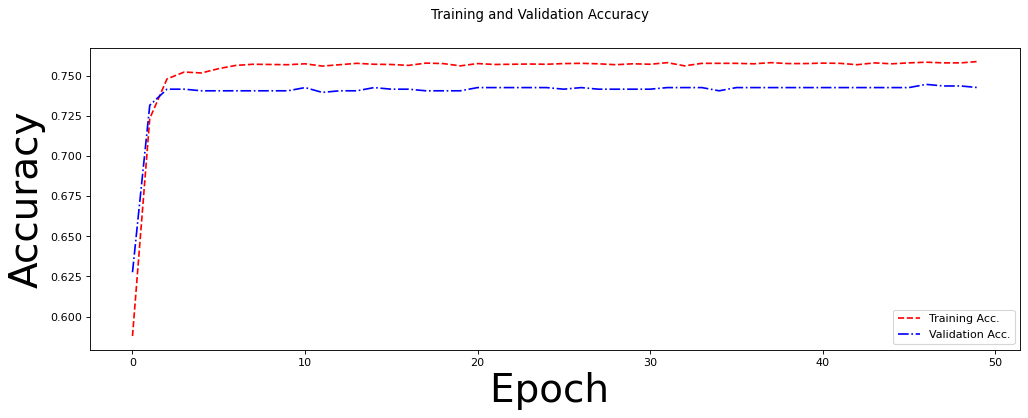

Test Accuracy : 0.7294589178356713
col_0    0    1
row_0          
0      289  139
1      131  439


<Figure size 432x288 with 0 Axes>

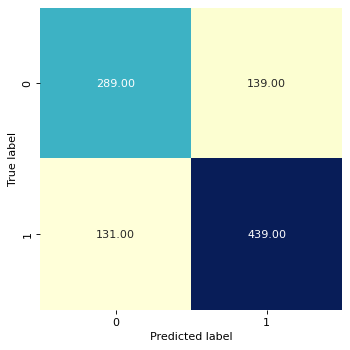

Train labeltab spread: [2914. 4086.]
RUNNING BUNDLE  TSdsp1  with model  model03
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 31, 18, 128)       1280      
_________________________________________________________________
activation_18 (Activation)   (None, 31, 18, 128)       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 71424)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 142850    
_________________________________________________________________
activation_19 (Activation)   (None, 2)                 0         
Total params: 144,130
Trainable params: 144,130
Non-trainable params: 0
_________________________________________________________________
Val labeltab spread: [ 816. 1182.

<ipython-input-6-cab6e0f8e18f>:177: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


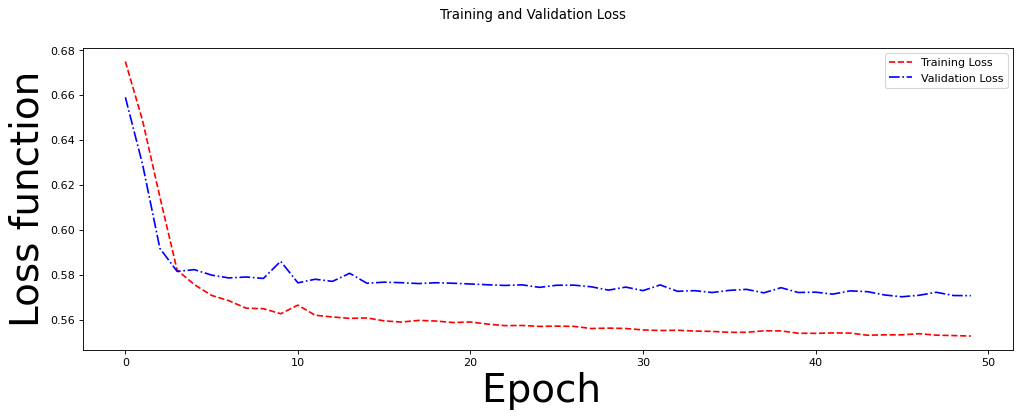

<ipython-input-6-cab6e0f8e18f>:202: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

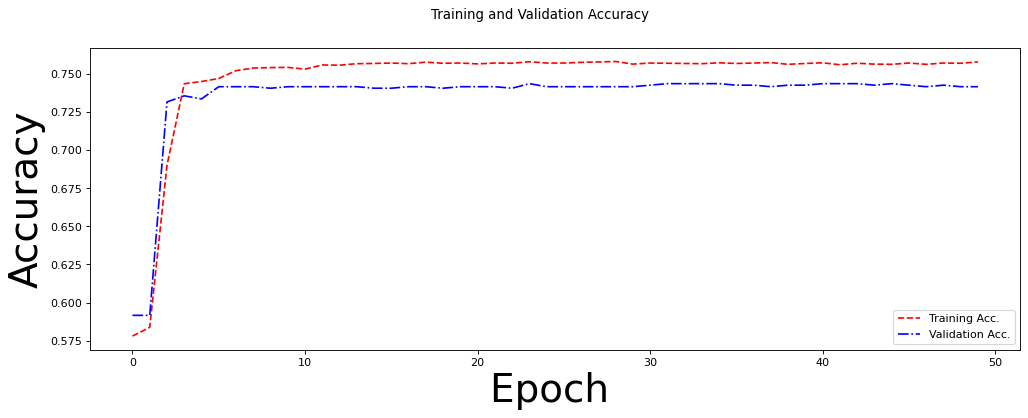

Test Accuracy : 0.7294589178356713
col_0    0    1
row_0          
0      289  139
1      131  439


<Figure size 432x288 with 0 Axes>

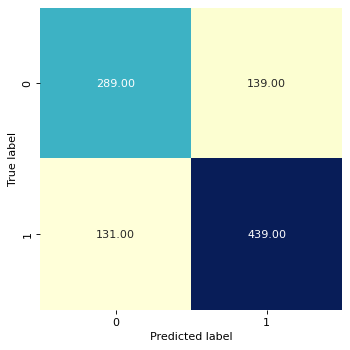

In [8]:
ModelNamesLs2=["model00","model01","model02","model03"]

ModelsLs2=[]  #BundleLs
BundleLs2=[TSdsp1]
###BigResuDF={"model":[],"bundle":[],"accu":[],"recall":[],"specif":[]}
for iBund, Bund in enumerate(BundleLs2):
    
    for Mo in ModelNamesLs2:
    #    NewSequentialModelazos2D(self;; BundleObj,modelname,nfiltLs,\
    #nbinsLs,nstrideLs,npoolLs,batchsize=20,epochs=15,learningR=0.01):
    
        ModObj=NewSequentialModelazos2D(Bund,Mo,[128],[3],[1],[2],batchsize=256,\
                                    epochs=50,learningR=0.0002)
        print("RUNNING BUNDLE ", Bund.name," with model ", ModObj.modelname)
        
        func="setup_"+Mo
        #model0,history0=make_and_run_model0(Gal,[16,12],[5,3],[2,2],batchsize=20)
        ModelsLs2.append(ModObj)
        getattr(ModObj,func)()
        ModObj.run_model()
        ModObj.plot_history()
        ModObj.predict()
        ModObj.make_confusion_mat(np.argmax(Bund.Test.labeltab,axis=-1))
        
        
        BigResuDF["model"].append(ModObj.modelname)
        BigResuDF["bundle"].append(Bund.name)
        for key in ResuLsAtt:
            BigResuDF[key].append(ModObj.results[key] )
        #BigResuDF["accu"].append(ModObj.results["accu"])

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9798169357998382739
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5475408468685026006
physical_device_desc: "device: XLA_CPU device"
]
Train labeltab spread: [2914. 4086.]
RUNNING BUNDLE  TSdsp1  with model  model00
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 27, 14, 128)       6400      
_________________________________________________________________
activation_22 (Activation)   (None, 27, 14, 128)       0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 48384)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 96770     
___________________

<ipython-input-6-cab6e0f8e18f>:177: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


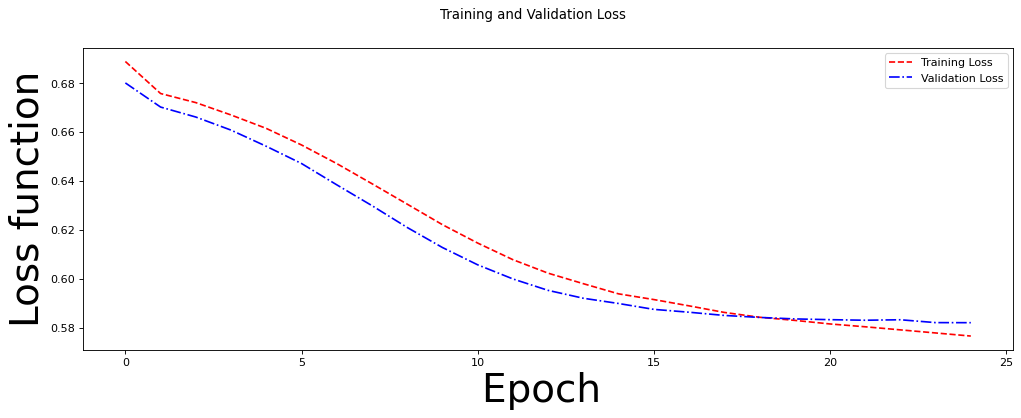

<ipython-input-6-cab6e0f8e18f>:202: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

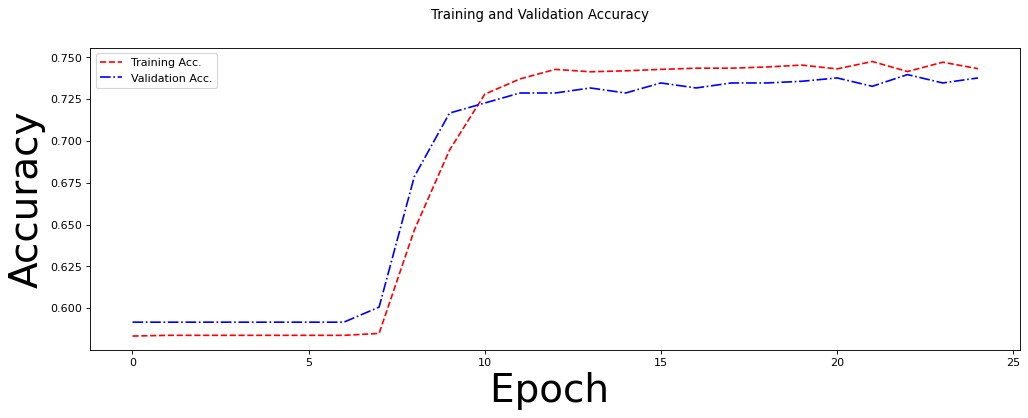

Test Accuracy : 0.7214428857715431
col_0    0    1
row_0          
0      288  140
1      138  432


<Figure size 432x288 with 0 Axes>

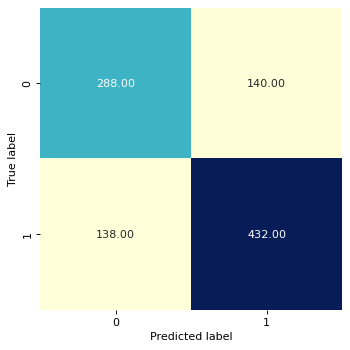

Train labeltab spread: [2914. 4086.]
RUNNING BUNDLE  TSdsp1  with model  model01
Val labeltab spread: [ 816. 1182.]
Epoch 1/25
14/14 [==============================] - 4s 284ms/step - loss: 0.6839 - accuracy: 0.5773 - val_loss: 0.6724 - val_accuracy: 0.5916
Epoch 2/25
14/14 [==============================] - 4s 280ms/step - loss: 0.6716 - accuracy: 0.5837 - val_loss: 0.6644 - val_accuracy: 0.5916
Epoch 3/25
14/14 [==============================] - 4s 280ms/step - loss: 0.6607 - accuracy: 0.5837 - val_loss: 0.6469 - val_accuracy: 0.5916
Epoch 4/25
14/14 [==============================] - 4s 280ms/step - loss: 0.6404 - accuracy: 0.6007 - val_loss: 0.6217 - val_accuracy: 0.6937
Epoch 5/25
14/14 [==============================] - 4s 280ms/step - loss: 0.6128 - accuracy: 0.7150 - val_loss: 0.5934 - val_accuracy: 0.7237
Epoch 6/25
14/14 [==============================] - 4s 281ms/step - loss: 0.5908 - accuracy: 0.7380 - val_loss: 0.5852 - val_accuracy: 0.7247
Epoch 7/25
14/14 [==============

<ipython-input-6-cab6e0f8e18f>:177: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


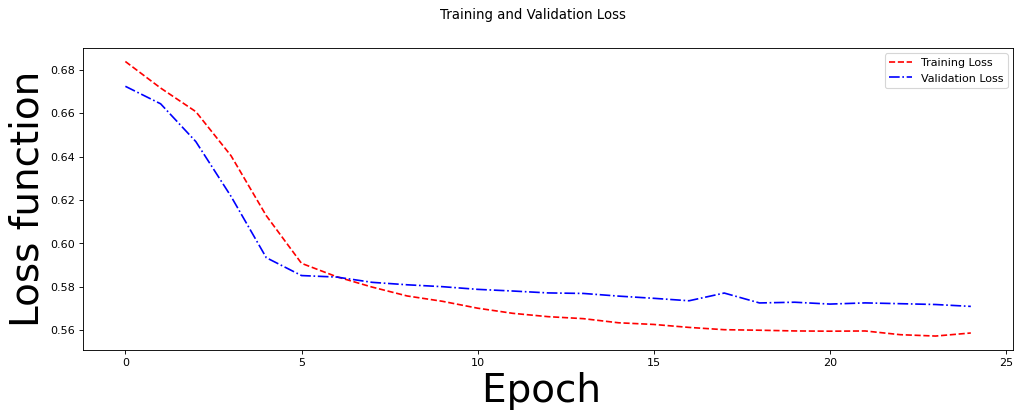

<ipython-input-6-cab6e0f8e18f>:202: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

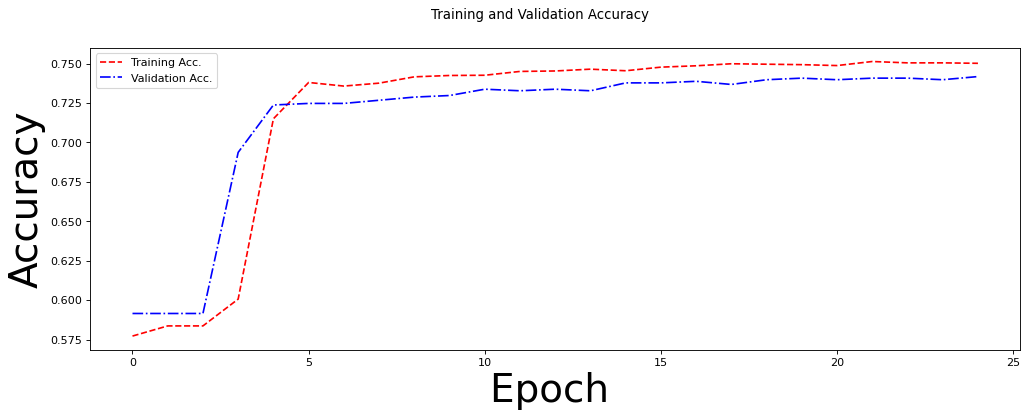

Test Accuracy : 0.7274549098196392
col_0    0    1
row_0          
0      285  143
1      129  441


<Figure size 432x288 with 0 Axes>

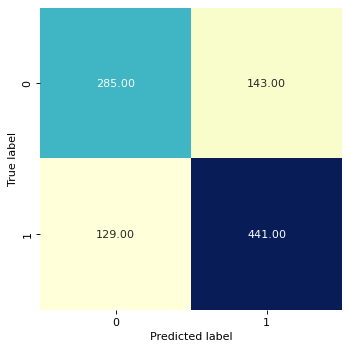

Train labeltab spread: [2914. 4086.]
RUNNING BUNDLE  TSdsp1  with model  model02
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 27, 14, 128)       6400      
_________________________________________________________________
activation_29 (Activation)   (None, 27, 14, 128)       0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 27, 14, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 25, 12, 15)        17295     
_________________________________________________________________
activation_30 (Activation)   (None, 25, 12, 15)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 23, 10, 15)        2040      
______________________________________

<ipython-input-6-cab6e0f8e18f>:177: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


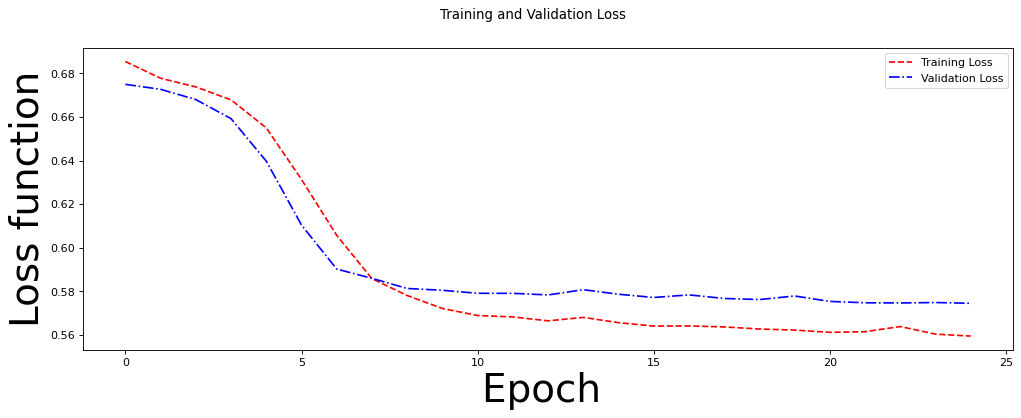

<ipython-input-6-cab6e0f8e18f>:202: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

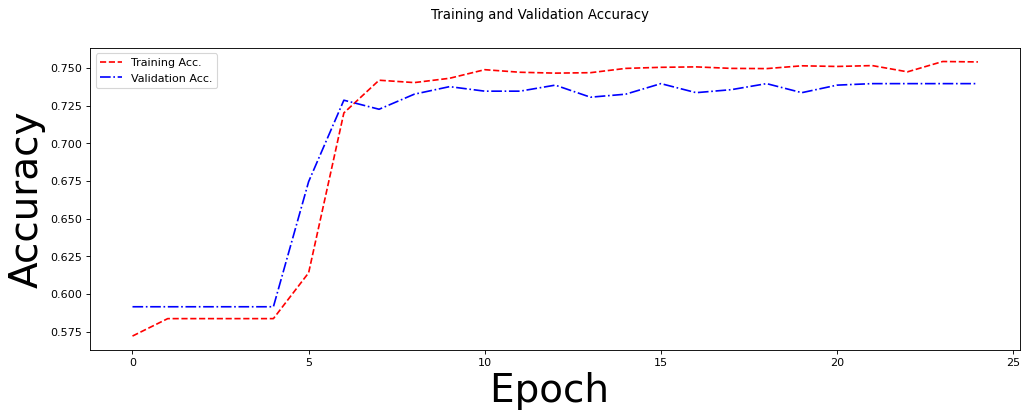

Test Accuracy : 0.7274549098196392
col_0    0    1
row_0          
0      292  136
1      136  434


<Figure size 432x288 with 0 Axes>

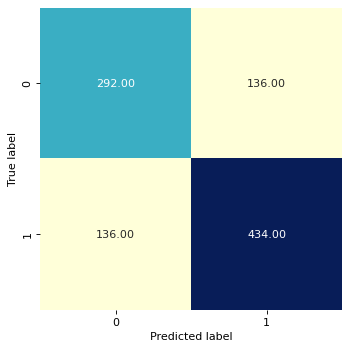

Train labeltab spread: [2914. 4086.]
RUNNING BUNDLE  TSdsp1  with model  model03
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 27, 14, 128)       6400      
_________________________________________________________________
activation_35 (Activation)   (None, 27, 14, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 25, 12, 15)        17295     
_________________________________________________________________
activation_36 (Activation)   (None, 25, 12, 15)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 23, 10, 15)        2040      
_________________________________________________________________
activation_37 (Activation)   (None, 23, 10, 15)        0         
______________________________________

<ipython-input-6-cab6e0f8e18f>:177: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


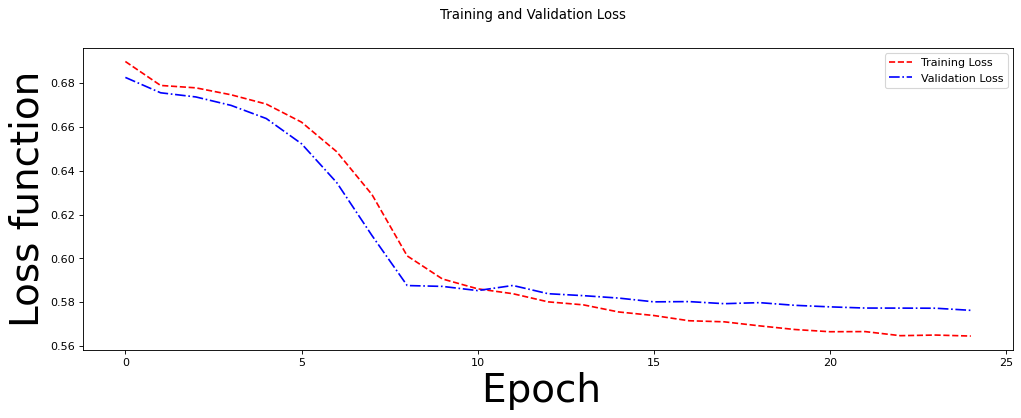

<ipython-input-6-cab6e0f8e18f>:202: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

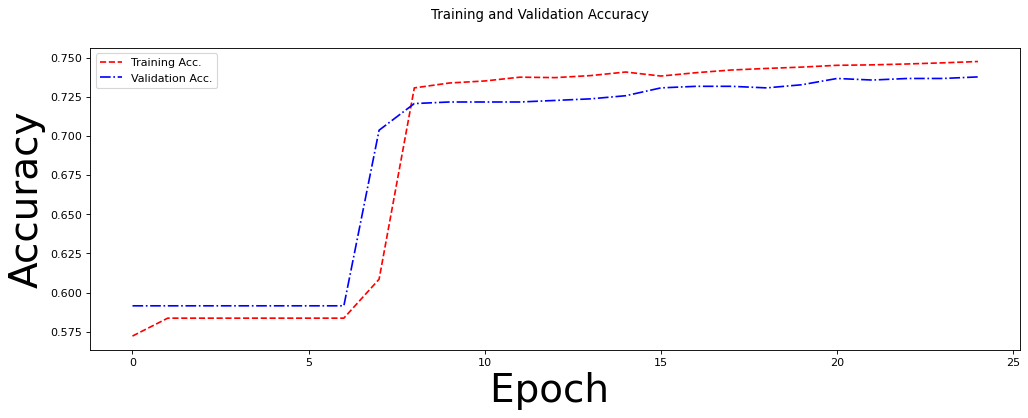

Test Accuracy : 0.7254509018036072
col_0    0    1
row_0          
0      286  142
1      132  438


<Figure size 432x288 with 0 Axes>

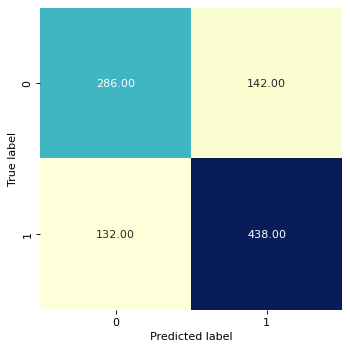

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.Session(config=config)
BundleLs=[TSdsp1]#,TSdsp8,TSdsp16]
#BundleLs=[TSdsp4,TSdsp8,TSdsp16]
#BundleLs=[TSdsp4]
ModelNamesLs=["model00","model01","model02","model03"]#,"model02"]
#ModelNamesLs=["model00","model01"]
ModelsLs=[]  #BundleLs
for iBund, Bund in enumerate(BundleLs):
    
    for Mo in ModelNamesLs:
        
        ModObj=NewSequentialModelazos2D(Bund,Mo,[128,15],[7,3],[1,1],[2,2],batchsize=512,\
                                    epochs=25,learningR=0.0001)
        print("RUNNING BUNDLE ", Bund.name," with model ", ModObj.modelname)
        
        func="setup_"+Mo
        #model0,history0=make_and_run_model0(Gal,[16,12],[5,3],[2,2],batchsize=20)
        ModelsLs.append(ModObj)
        getattr(ModObj,func)()
        ModObj.run_model()
        ModObj.plot_history()
        ModObj.predict()
        ModObj.make_confusion_mat(np.argmax(Bund.Test.labeltab,axis=-1))
        BigResuDF["model"].append(ModObj.modelname)
        BigResuDF["bundle"].append(Bund.name)
        for key in ResuLsAtt:
            BigResuDF[key].append(ModObj.results[key] )

In [11]:
BigResuDF=pd.DataFrame(BigResuDF)
display(BigResuDF)

model  bundle      accu    recall    specif       ppv       npv
0   model00  TSdsp1  0.729459  0.764912  0.682243  0.762238  0.685446
1   model01  TSdsp1  0.727455  0.770175  0.670561  0.756897  0.686603
2   model02  TSdsp1  0.729459  0.771930  0.672897  0.758621  0.688995
3   model03  TSdsp1  0.729459  0.770175  0.675234  0.759516  0.688095
4   model00  TSdsp1  0.729459  0.770175  0.675234  0.759516  0.688095
5   model01  TSdsp1  0.729459  0.766667  0.679907  0.761324  0.686321
6   model02  TSdsp1  0.729459  0.770175  0.675234  0.759516  0.688095
7   model03  TSdsp1  0.729459  0.770175  0.675234  0.759516  0.688095
8   model00  TSdsp1  0.721443  0.757895  0.672897  0.755245  0.676056
9   model01  TSdsp1  0.727455  0.773684  0.665888  0.755137  0.688406
10  model02  TSdsp1  0.727455  0.761404  0.682243  0.761404  0.682243
11  model03  TSdsp1  0.725451  0.768421  0.668224  0.755172  0.684211

In [12]:
display(BigResuDF)

model  bundle      accu    recall    specif       ppv       npv
0   model00  TSdsp1  0.729459  0.764912  0.682243  0.762238  0.685446
1   model01  TSdsp1  0.727455  0.770175  0.670561  0.756897  0.686603
2   model02  TSdsp1  0.729459  0.771930  0.672897  0.758621  0.688995
3   model03  TSdsp1  0.729459  0.770175  0.675234  0.759516  0.688095
4   model00  TSdsp1  0.729459  0.770175  0.675234  0.759516  0.688095
5   model01  TSdsp1  0.729459  0.766667  0.679907  0.761324  0.686321
6   model02  TSdsp1  0.729459  0.770175  0.675234  0.759516  0.688095
7   model03  TSdsp1  0.729459  0.770175  0.675234  0.759516  0.688095
8   model00  TSdsp1  0.721443  0.757895  0.672897  0.755245  0.676056
9   model01  TSdsp1  0.727455  0.773684  0.665888  0.755137  0.688406
10  model02  TSdsp1  0.727455  0.761404  0.682243  0.761404  0.682243
11  model03  TSdsp1  0.725451  0.768421  0.668224  0.755172  0.684211